# Introduction and Problem Definition

Hand gesture recognition (HGR) is a major facet of human-computer interaction. With the modern emergence of the mediums of consumer Augmented Reality (AR) and Virtual Reality (VR), HGR enables a fluid, intuitive mechanism for users to interact with AR/VR environments via swipes, rotations and other similar patterns of hand movement, as opposed to traditional keyboard and mouse input systems.

Hence, it is important that any such system is highly accurate, efficient and able to identify distinct hand gestures successfully in spite of variations in orientation, lighting, and size. In this project, we will be experimenting with various preprocessing methods and hand gesture classification networks to find an optimised solution for this particular use case.


## Codebase Overview

This codebase was originally a fork of the code provided by the [HaGRID](https://github.com/hukenovs/hagrid) hand gesture recognition dataset repository. The most significant portions of it have been modified and adapted by our team to suit our particular use case. The image below outlines what modules of the code have been modified by us / added by us and what parts of the code are from the original repository, and how they link together:

 - **Blue**: added/modified by us
 - **Yellow**: from the original repository


To summarise, we have written our own code to split a subset of the dataset in the way we want, we have added code and preprocessing options to either normalize or grayscale the image, and we have implemented a custom configurable PerceptronPosseResNet class through which we can experiment with multiple Residual Neural Network architectures.

## IMPORTANT NOTES

**NOTE: Any code annotated with 'perceptron-posse' is code that has been added by us**

This codebase is very complex, and requires various modules, a particular directory structure and import hierarchy that makes it impossible to run as a notebook or in Google Colab.

To run this code on your local machine, please clone and run the steps at the top of this repository: https://github.com/D0D0123/hagrid

You may need a Debian-based VM or Docker image, as this is confirmed to run on Linux. You can consult the demonstration at the end of the submitted video presentation for the expected behaviour of the code.

Run `tensorboard --logdir=experiments` from within `hagrid/classifier`, and navigate to `localhost:6006` to view all results in much more detail.


# Data Sources, Exploration and Preparation

AR/VR application controls generally utilise combinations of a few, simple, fairly distinct hand gestures. Hence, the ideal dataset for this project should contain a range of pictures under various lighting/distance conditions, should be primarily divided into a smaller number of distinct gestures, and the resolution of the images should match those used in AR/VR headset cameras (i.e. 720p or 1080p). 

Despite an abundance of hand gesture datasets available online, not all met these requirements. For instance, the MNIST and American Sign Language Datasets contain mostly homogenous pictures (focusing on a single subject and scene), with a large number of complicated and unvaried gesture classes. Other datasets, including the EgoGesture, nvGesture, ChaLearn, IsoGD, IPN Hand and ArASL faced similar issues of uniformity and division into numerous gesture classes with little variation between them.

We settled upon a dataset called **HaGRID**, intended for training HGR networks for home automation and video call controls. This dataset “consists of about half a million FullHD (1920 × 1080) RGB images with 18 gestures ... each serv[ing] one semiotic functional role ... with at least 34,730 unique scenes”. This fulfilled our initial requirements.

**Link to Dataset Downloads**: https://github.com/hukenovs/hagrid#downloads

Each image in the dataset is also accompanied by an annotation, describing the target class the image belongs to, as well as the coordinates of the bounding box of each hand in the image. In terms of further data preparation, we chose an equally distributed subsample of the entire dataset, and only a subset of 10 gesture classes (like, dislike, ok, mute, call, fist, stop, stop inv., peace, peace inv.) that we felt were most relevant to AR/VR interaction. This subsample was **split 70:30 for training and testing** - 3500 images were used for training, and 1500 images were used for testing, with the image’s target classifications being evenly distributed across the 10 gesture classes.

Having an equal distribution is useful in the context of this model as we do not want the model to prioritise one class over another - in a dynamic and fast paced AR/VR environment all gestures would serve important functions. A subsample was chosen due to hardware and storage constraints as well - the entire dataset totals 716 GB, and would take an unreasonable amount of time to train with.

**Bounding Boxes** - The main feature extraction method employed by the HaGRID team were ‘bounding boxes’. Crowd workers would draw a red border box around the gesture on each image, and a green border box around the hand without the gesture if it is completely in the frame (Supp. Fig. 1). By doing so, the hagrid team was able to decrease the input size from (1920 × 1080) to just (224 x 224). 

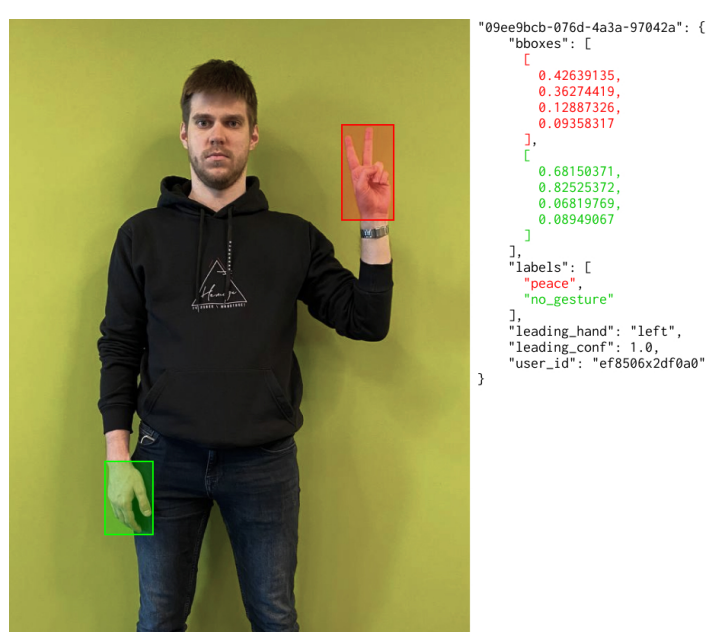

The additional preprocessing methods that we employed are as follows:

**Normalization** - The nature of the bounding box means that every pixel within its boundary has a high probability of containing useful information about the final hand gesture. The normalisation of RGB channels of all images within the dataset helps to further facilitate this by ensuring all pixels have the same distribution, hence causing all pixels to have “equal importance”.

**Grayscaling** - Another method of preprocessing the data was to convert the RGB images to grayscale. Although grayscaling is generally useful for the compression of image data to help improve computational load at the expense of information loss, we wanted to explore the impact of this information loss on the predictive power of our models - and whether this trade-off would be justified in an AR/VR context. 


## Splitting Datasets and Annotations

Each image in the dataset is accompanied by a JSON annotation containing a bounding box and target gesture. These scripts automate the process of correctly splitting the overall dataset into training and testing sets.

In [2]:
import os
import shutil
import json
from pprint import pprint

In [ ]:
'''
split_dataset.py
'''

# perceptron-posse
# 350 : 150 images gives a 70 : 30 split, 400 : 100 gives a 80 : 20 split

SPLIT_TRAIN = False

for gesture in ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'peace', 'peace_inverted', 'stop', 'stop_inverted']:
    if SPLIT_TRAIN == True:
        imgnames = sorted(os.listdir(f"./test_dataset/{gesture}"))
        for i in range(350):
            shutil.copy(f'./test_dataset/{gesture}/{imgnames[i]}', f'./subsamples_train1/{gesture}/{imgnames[i]}')
    else: # split test
        imgnames = sorted(os.listdir(f"./test_dataset/{gesture}"), reverse=True)
        for i in range(150):
            shutil.copy(f'./test_dataset/{gesture}/{imgnames[i]}', f'./subsamples_test1/{gesture}/{imgnames[i]}')

In [ ]:
'''
split_annotations.py
'''

# perceptron-posse
for gesture in ["call", "peace", "peace_inverted", "like", "dislike", "ok", "mute", "stop", 
"stop_inverted", "fist"]:
    print(f'current gesture: {gesture}')
    f = open(f"annotations1/{gesture}.json", "r")

    test_imgnames = os.listdir(f'subsamples_test1/{gesture}/')
    train_imgnames = os.listdir(f'subsamples_train1/{gesture}/')

    data = json.load(f)

    out_test_f = open(f"annotations_test1/{gesture}.json", "w")
    out_train_f = open(f"annotations_train1/{gesture}.json", "w")

    out_test_dict = {}
    for imgname in sorted(test_imgnames):
        name = imgname[:-4]
        out_test_dict[name] = data[name]

    out_train_dict = {}
    for imgname in sorted(train_imgnames):
        name = imgname[:-4]
        out_train_dict[name] = data[name]

    json.dump(out_test_dict, out_test_f, indent=4)
    json.dump(out_train_dict, out_train_f, indent=4)

    f.close()
    out_test_f.close()
    out_train_f.close()


## Dataset Manipulation

A class that prepares the dataset to be passed into the network - it has been modified to normalize, grayscale or do nothing to the image based on the *preprocess_option* argument passed in.

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import logging
import torch.utils.data

from PIL import Image, ImageOps
from typing import Dict, Tuple, List
from omegaconf import DictConfig
from preprocess import get_crop_from_bbox, Compose

from torchvision import transforms

In [ ]:
'''
dataset.py
'''

FORMATS = (".jpeg", ".jpg", ".jp2", ".png", ".tiff", ".jfif", ".bmp", ".webp", ".heic")


class GestureDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for gesture classification pipeline
    """

    def __init__(
            self,
            is_train: bool,
            conf: DictConfig,
            transform: Compose = None,
            is_test: bool = False,
            preprocess_option: str = None
    ) -> None:

        """
        Custom Dataset for gesture classification pipeline

        Parameters
        ----------
        is_train : bool
            True if collect train dataset else False
        is_test: Bool
            For metrics calculation on test set
        conf : DictConfig
            Config with training params
        transform : Compose
            Compose of transforms
        preprocess_option: str
            Option to normalize, grayscale or do nothing with the images - perceptron-posse
        """
        self.conf = conf
        self.transform = transform
        self.is_train = is_train
        self.preprocess_option = preprocess_option

        self.labels = {label: num for (label, num) in
                       zip(self.conf.dataset.targets, range(len(self.conf.dataset.targets)))}

        self.leading_hand = {"right": 0, "left": 1}

        subset = self.conf.dataset.get("subset", None)

        self.annotations = self.__read_annotations(subset)

        users = self.annotations["user_id"].unique()
        users = sorted(users)
        random.Random(self.conf.random_state).shuffle(users)

        train_users = users[:int(len(users) * 0.8)]
        val_users = users[int(len(users) * 0.8):]

        self.annotations = self.annotations.copy()

        if not is_test:
            if is_train:
                self.annotations = self.annotations[self.annotations["user_id"].isin(train_users)]
            else:
                self.annotations = self.annotations[self.annotations["user_id"].isin(val_users)]

    @staticmethod
    def __get_files_from_dir(pth: str, extns: Tuple, subset: int = None) -> List:
        """
        Get list of files from dir according to extensions(extns)

        Parameters
        ----------
        pth : str
            Path ot dir
        extns: Tuple
            Set of file extensions
        subset : int
            Length of subset for each target
        """
        if not os.path.exists(pth):
            logging.warning(f"Dataset directory doesn't exist {pth}")
            return []
        files = [f for f in os.listdir(pth) if f.endswith(extns)]
        if subset is not None:
            files = files[:subset]
        return files

    def __read_annotations(self, subset: int = None) -> pd.DataFrame:
        """
        Read annotations json

        Parameters
        ----------
        subset : int
            Length of subset for each target
        """
        exists_images = []
        annotations_all = pd.DataFrame()
        path_to_json = os.path.expanduser(self.conf.dataset.annotations)
        for target in self.conf.dataset.targets:
            target_tsv = os.path.join(path_to_json, f"{target}.json")
            if os.path.exists(target_tsv):
                json_annotation = json.load(open(
                    os.path.join(path_to_json, f"{target}.json")
                ))

                json_annotation = [dict(annotation, **{"name": f"{name}.jpg"}) for name, annotation in zip(
                    json_annotation, json_annotation.values()
                )]

                annotation = pd.DataFrame(json_annotation)

                annotation["target"] = target
                annotations_all = pd.concat([annotations_all, annotation], ignore_index=True)
                exists_images.extend(
                    self.__get_files_from_dir(os.path.join(self.conf.dataset.dataset, target),
                                              FORMATS, subset))
            else:
                logging.info(f"Databse for {target} not found")

        annotations_all["exists"] = annotations_all["name"].isin(exists_images)

        return annotations_all[annotations_all["exists"]]

    def __prepare_image_target(
            self,
            target: str,
            name: str,
            bboxes: List,
            labels: List,
            leading_hand: str
    ) -> Tuple[Image.Image, str, str]:
        """
        Crop and padding image, prepare target

        Parameters
        ----------
        target : str
            Class name
        name : str
            Name of image
        bboxes : List
            List of bounding boxes [xywh]
        labels: List
            List of labels
        leading_hand : str
            Leading hand class name
        """
        image_pth = os.path.join(self.conf.dataset.dataset, target, name)

        image = Image.open(image_pth).convert("RGB")

        width, height = image.size

        choice = np.random.choice(["gesture", "no_gesture"], p=[0.7, 0.3])

        bboxes_by_class = {}

        for i, bbox in enumerate(bboxes):
            x1, y1, w, h = bbox
            bbox_abs = [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]
            if labels[i] == "no_gesture":
                bboxes_by_class["no_gesture"] = (bbox_abs, labels[i])
            else:
                bboxes_by_class["gesture"] = (bbox_abs, labels[i])

        if choice not in bboxes_by_class:
            choice = list(bboxes_by_class.keys())[0]

        if self.is_train:
            box_scale = np.random.uniform(low=1.0, high=2.0)
        else:
            box_scale = 1.0

        image_cropped, bbox_orig = get_crop_from_bbox(image, bboxes_by_class[choice][0], box_scale=box_scale)

        image_resized = ImageOps.pad(image_cropped, tuple(self.conf.dataset.image_size), color=(0, 0, 0))

        gesture = bboxes_by_class[choice][1]

        leading_hand_class = leading_hand
        if gesture == "no_gesture":
            leading_hand_class = "right" if leading_hand == "left" else "left"

        return image_resized, gesture, leading_hand_class

    def __len__(self) -> int:
        return self.annotations.shape[0]

    def __getitem__(self, index: int) -> Tuple[Image.Image, Dict]:
        """
        Get item from annotations

        Parameters
        ----------
        index : int
            Index of annotation item
        """
        row = self.annotations.iloc[[index]].to_dict('records')[0]

        image_resized, gesture, leading_hand = self.__prepare_image_target(
            row["target"],
            row["name"],
            row["bboxes"],
            row["labels"],
            row["leading_hand"]
        )

        label = {"gesture": self.labels[gesture],
                 "leading_hand": self.leading_hand[leading_hand]}

        if self.transform is not None:
            image_resized, label = self.transform(image_resized, label)

        ####### added code to normalise and grayscale images - perceptron-posse #######
        if self.preprocess_option == 'normalize':
            mean, std = image_resized.mean([1, 2]), image_resized.std([1, 2])
            transform_norm = transforms.Normalize(mean, std)
            image_normalized = transform_norm(image_resized)
            return image_normalized, label
        
        elif self.preprocess_option == 'grayscale':
            transform_grayscale = transforms.Grayscale(num_output_channels=3)
            image_grayscaled = transform_grayscale(image_resized)
            return image_grayscaled, label
        
        elif self.preprocess_option == None:
            return image_resized, label
        
        else:
            raise RuntimeError("Incompatible argument for preprocess_option")


        


## Cropping Image, Converting to Tensor

This code crops the images according to the bounding box in their corresponding annotation.

In [ ]:
import numpy as np

from PIL import Image
from torch import nn, Tensor
from typing import Tuple, Dict, Optional, List
from torchvision.transforms import functional as F

In [ ]:
'''
preprocess.py
'''


def get_crop_from_bbox(image: Image.Image, bbox: List, box_scale: float = 1.) -> Tuple[Image.Image, np.array]:
    """
    Crop bounding box from image

    Parameters
    ----------
    image : Image.Image
        Source image for crop
    bbox : List
        Bounding box [xyxy]
    box_scale: float
        Scale for bounding box crop
    """
    int_bbox = np.array(bbox).round().astype(np.int32)

    x1 = int_bbox[0]
    y1 = int_bbox[1]
    x2 = int_bbox[2]
    y2 = int_bbox[3]
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = h = max(x2 - x1, y2 - y1)
    x1 = max(0, cx - box_scale * w // 2)
    y1 = max(0, cy - box_scale * h // 2)
    x2 = cx + box_scale * w // 2
    y2 = cy + box_scale * h // 2
    x1, y1, x2, y2 = list(map(int, (x1, y1, x2, y2)))

    crop_image = image.crop((x1, y1, x2, y2))
    bbox_orig = np.array([x1, y1, x2, y2]).reshape(2, 2)

    return crop_image, bbox_orig


class Compose:
    def __init__(self, transforms: List[nn.Module]):
        self.transforms = transforms

    def __call__(self, image, target) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensor(nn.Module):
    @staticmethod
    def forward(
            image: Tensor,
            target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target


def get_transform() -> Compose:
    transforms = [ToTensor()]
    return Compose(transforms)


# Method and Models

The necessity of feature extraction in this task made a convolutional neural network a suitable choice for classifying the images, while the complexity of the task warranted a deeper neural network than would be reasonable using the standard convolutional neural network architecture. For this reason, a residual neural network (ResNet) was desirable, as the skip connections between layers allowed increased complexity of the model with fewer vanishing or exploding gradients.

The two main aspects we wanted to explore through our experimentation were the effects of three different preprocessing methods (none, normalisation and grayscaling) on training time and accuracy, and how the alteration of block and layer complexity had an impact on the predictive power of the ResNet. Hence, we built three custom ResNet model architectures, based on this [paper](https://arxiv.org/pdf/1512.03385.pdf).

 - a ResNet18 model, composed of an input layer, 4 “double-blocks” with skip connections between, and an output layer.
 - a ResNet10 model, composed of an input layer, 4 “single-blocks” with skip connections between, and an output layer.
 - a ResNet20 model, composed of an input layer, 3 “triple-blocks” with skip connections between and an output layer.
 - Each "block" consisted of two convolutional layers separated by batch-normalisation layers followed by a Rectified Linear Unit (ReLU) activation layer. The output layers for all three models was an 2-D average pooling layer followed by a fully-connected layer.  

Please refer to the linked paper as well as the diagrams below for more specific details of each model.

In regards to hyper-parameter tuning, we decided to use the values employed by the HagRID team due to their extensive research on the total dataset. The optimizer parameters were as follows: 
 - Learning Rate = 0.005
 - Momentum = 0.9
 - Weight Decay = 0.0005
 
and the training parameters were: 

 - Maximum Epochs = 75
 - Training Batch Size = 64
 - Test Batch Size = 20.

We ran 9 experiments in total - each being a permutation of the three preprocessing options (normalisation, grayscaling, none) with the three custom ResNet architectures. The setup which combined no preprocessing of image data with the standard ResNet18 architecture functioned as a sort of ‘control’ or base point of comparison, as it was the setup that was most discussed in relevant literature. 

Each of these nine setups were trained with the training dataset, and tested against the testing dataset, to produce 18 distinct sets of useful log data. We utilised the inbuilt HaGRID tensorboard logging system to log the accuracy, f1-score, cross entropy loss and confusion matrix of the networks in each step.

The following series of code includes all the code relevant to training and testing the network.

## Custom Residual Neural Network Class Implementation

This defines a Residual Neural Network class (PerceptronPosseResNet), composed of residual blocks (CustomBlock). It allows various RNN layer architectures to be configured from the base class. The architecture of the RNN can be passed in as an array of layers and the number of blocks in each layer - i.e. [1, 1, 1, 1] means 4 'layers' with 1 block per layer. This is based loosely on the [torchvision.models](https://pytorch.org/vision/stable/models.html) builtin ResNet model, as well as the corresponding [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).

The following image visually outlines three such architectures, each named after the numbers of individual convolutional layers they contain:



In [ ]:
from typing import Type, Any, Callable, List, Optional

import torch
import torch.nn as nn
from torch import Tensor

In [ ]:
'''
custom_resnet.py
'''

###################################################################################################
# perceptron-posse

class CustomBlock(nn.Module):
    """
    Residual block for ResNet
    - Consists of two convolutional layers with 2-d batch normalization between followed by a dropout layer and 
    - ReLU activation function
    """
    def __init__(self, 
                in_channels, 
                out_channels, 
                stride = 1,
                identity_downsample: Optional[nn.Module] = None,
                ):
        super(CustomBlock, self).__init__()
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.6)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        # saving weights at beginning to reapply at end of block 
        identity = x

        # main block architecture - 2 conv layers with batch norm and relu
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        # dropout layer to help with overfitting - not necessary since our dataset is fairly small
        # x = self.dropout(x)

        # if there is a size mismatch, downsample identity before readding
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # reapply weights from beginning of block
        x += identity
        x = self.relu(x)
        return x

class PerceptronPosseResNet(nn.Module):
    def __init__(
        self,
        block: CustomBlock,
        layers: List[int],
        num_classes: int = 1000,
    ) -> None:
        super().__init__()
        
        self.num_layers = len(layers)

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._custom_make_layers(block, 64, layers[0], stride=1)
        self.layer2 = self._custom_make_layers(block, 128, layers[1], stride=2)
        self.layer3 = self._custom_make_layers(block, 256, layers[2], stride=2)
        self.layer4 = None
        self.avgpool = None
        self.fc = None
        if (self.num_layers == 4):
            self.layer4 = self._custom_make_layers(block, 512, layers[3], stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, num_classes)
        elif (self.num_layers == 3):
            self.layer4 = lambda x : x
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(256, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _custom_make_layers(
                    self, 
                    block,
                    intermediate_channels,
                    num_residual_blocks,
                    stride):
        """Function to make resnet layers based on given parameters"""
        layers = []

        # used if size of identity is incompatible with output of block
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(intermediate_channels)
        )

        layers.append(
            block(
                self.in_channels, 
                intermediate_channels, 
                stride, 
                identity_downsample
            )
        )
        
        self.in_channels = intermediate_channels # 256
        for i in range(num_residual_blocks - 1):
            layers.append(
                block(
                    self.in_channels, 
                    intermediate_channels
                )
            ) # 256 -> 64, 64*4 (256) again
        
        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: CustomBlock,
    layers: List[int],
    **kwargs: Any,
) -> PerceptronPosseResNet:
    model = PerceptronPosseResNet(block, layers, **kwargs)
    return model


### duplicate and customise to make custom resnet classes

def resnet18(**kwargs: Any) -> PerceptronPosseResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    """
    return _resnet(CustomBlock, [2, 2, 2, 2], **kwargs)

def resnet10(**kwargs: Any) -> PerceptronPosseResNet:
    r"""ResNet-10 model
    """
    return _resnet(CustomBlock, [1, 1, 1, 1], **kwargs)

def resnet20(**kwargs: Any) -> PerceptronPosseResNet:
    r"""ResNet-20 model
    """
    return _resnet(CustomBlock, [3, 3, 3], **kwargs)

###################################################################################################

## ResNet Wrapper Configuration

A wrapper class for the resnet that is used to build the model for training - this existed in the original repository, and has been simplified and adapted to our custom models.

In [ ]:
import torch

from typing import Dict
from torch import nn, Tensor
from .custom_resnet import resnet18, resnet10, resnet20

In [ ]:
'''
resnet.py
'''

# perceptron-posse

class ResNet(nn.Module):
    """
    Custom two headed ResNet configuration
    """

    def __init__(
            self,
            num_classes: int,
            restype: str = "ResNet18",
    ) -> None:
        """
        Custom two headed ResNet configuration

        Parameters
        ----------
        num_classes : int
            Number of classes for each task
        freezed : bool
            Freezing model parameters or not
        """

        super().__init__()
        
        #### perceptron-posse ########

        pposse_model = None
        if restype == 'ResNet18':
            pposse_model = resnet18()
        elif restype == 'ResNet10':
            pposse_model = resnet10()
        elif restype == 'ResNet20':
            pposse_model = resnet20()

        self.backbone = None
        if pposse_model.num_layers == 4:
            self.backbone = nn.Sequential(
                pposse_model.conv1,
                pposse_model.bn1,
                pposse_model.relu,
                pposse_model.maxpool,
                pposse_model.layer1,
                pposse_model.layer2,
                pposse_model.layer3,
                pposse_model.layer4,
                pposse_model.avgpool
            )
        elif pposse_model.num_layers == 3:
            self.backbone = nn.Sequential(
                pposse_model.conv1,
                pposse_model.bn1,
                pposse_model.relu,
                pposse_model.maxpool,
                pposse_model.layer1,
                pposse_model.layer2,
                pposse_model.layer3,
                pposse_model.avgpool
            )

        num_features = pposse_model.fc.in_features
        
        ##############################

        self.classifier = nn.Sequential(
            nn.Linear(num_features, num_classes),
        )

        self.leading_hand = nn.Sequential(
            nn.Linear(num_features, 2),
        )

    def forward(self, img: Tensor) -> Dict:
        x = self.backbone(img)
        x = torch.flatten(x, 1)
        gesture = self.classifier(x)

        leading_hand = self.leading_hand(x)

        return {'gesture': gesture, 'leading_hand': leading_hand}


## General Helper Utility Functions

In [ ]:
import torch
import numpy as np
import random
import logging
import os
import torch.nn as nn

from typing import Dict, List, Tuple, Set
from models.mobilenetv3 import MobileNetV3
from models.resnet import ResNet
from models.vit import Vit
from torch.utils.tensorboard import SummaryWriter

In [ ]:
'''
utils.py
'''

def add_metrics_to_tensorboard(writer: SummaryWriter, metrics: Dict, epoch: int, mode: str, target: str) -> None:
    """
    Add metrics to Tensorboard logs

    Parameters
    ----------
    writer : SummaryWriter
        Tensorboard log writer
    metrics : Dict
        Metrics value
    epoch : int
        Number of epoch
    mode : str
        Mode valid or train
    target : str
        Target name: gesture or leading_hand
    """
    logging.info(f'{mode}: metrics for {target}')
    logging.info(metrics)
    for key, value in metrics.items():
        writer.add_scalar(f'{key}_{target}/{mode}', value, epoch)


def add_params_to_tensorboard(writer: SummaryWriter, params: Dict, epoch: int, obj: str, not_logging: Set) -> None:
    """
    Add optimizer params to Tensorboard logs

    Parameters
    ----------
    writer : SummaryWriter
        Tensorboard log writer
    params : Dict
        Optimizer params for logging
    epoch : int
        Number of epoch
    obj : str
        Optimizer or learning scheduler for params logging
    not_logging : List
        Parameters that should not be logged
    """
    for param, value in params.items():
        if param not in not_logging:
            writer.add_scalar(f'{obj}/{param}', value, epoch)


def set_random_state(random_seed: int) -> None:
    """
    Set random seed for torch, numpy, random

    Parameters
    ----------
    random_seed: int
        Random seed from config
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)


def save_checkpoint(
        output_dir: str,
        config_dict: Dict,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        epoch: int,
        name: str
) -> None:
    """
    Save checkpoint dictionary

    Parameters
    ----------
    output_dir : str
        Path to directory model checkpoint
    config_dict : Dict
        Config dictionary
    model : nn.Module
        Model for checkpoint save
    optimizer : torch.optim.Optimizer
        Optimizer
    epoch : int
        Epoch number
    name : str
        Model name
    """
    if not os.path.exists(output_dir):
        os.makedirs(os.path.join(output_dir), exist_ok=True)

    checkpoint_path = os.path.join(output_dir, f'{name}.pth')

    checkpoint_dict = {
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'config': config_dict
    }
    torch.save(checkpoint_dict, checkpoint_path)

##### perceptron-posse ####

def build_model(
        model_name: str,
        num_classes: int,
        device: str,
        checkpoint: str = None,
) -> nn.Module:
    """
    Build modela and load checkpoint

    Parameters
    ----------
    model_name : str
        Model name e.g. ResNet18, MobileNetV3_small, Vitb32
    num_classes : int
        Num classes for each task
    checkpoint : str
        Path to model checkpoint
    device : str
        Cpu or CUDA device
    """
    models = {
        'ResNet18': ResNet(
            num_classes=num_classes,
            restype='ResNet18',
        ),
        'ResNet10': ResNet(
            num_classes=num_classes,
            restype='ResNet10',
        ),
        'ResNet20': ResNet(
            num_classes=num_classes,
            restype='ResNet20',
        ),
    }

    model = models[model_name]
    print(f' ---------- Chosen Model: {model_name} ---------- ')

    if checkpoint is not None:
        checkpoint = os.path.expanduser(checkpoint)
        if os.path.exists(checkpoint):
            checkpoint = torch.load(checkpoint, map_location=torch.device(device))["state_dict"]
            model.load_state_dict(checkpoint, strict=False)

    model.to(device)
    return model


def collate_fn(batch: List) -> Tuple:
    """
    Collate func for dataloader

    Parameters
    ----------
    batch : List
        Batch of data
    """
    return tuple(zip(*batch))



## Training/Testing Process

Code that defines the operation of training steps and epochs, as well as test evaluation.

In [ ]:
import math
from collections import defaultdict
import torch.utils
import torch.optim
import torch

import logging
import torch.nn as nn

from omegaconf import DictConfig, OmegaConf
from torch.utils.tensorboard import SummaryWriter
from metrics import get_metrics
from utils import collate_fn, add_metrics_to_tensorboard, add_params_to_tensorboard, save_checkpoint

In [ ]:
'''
train.py
'''

class TrainClassifier:
    """
    Gesture classification training pipeline:
        -initialize dataloaders
        for n epochs from training config:
            -run one epoch
            -eval on validation set
            - metrics calculation
            -save checkpoint
    """

    @staticmethod
    def eval(
            model: nn.Module,
            conf: DictConfig,
            epoch: int,
            test_loader: torch.utils.data.DataLoader,
            writer: SummaryWriter,
            mode: str = "valid"
    ) -> float:
        """
        Evaluation model on validation set and metrics calc

        Parameters
        ----------
        model : nn.Module
            Model for eval
        conf : DictConfig
            Config with training params
        epoch : int
            Number of epoch
        test_loader : torch.utils.data.DataLoader
            Dataloader for sampling test data
        writer : SummaryWriter
            Tensorboard log writer
        mode : str
            Eval mode valid or test
        """
        f1_score = None
        if test_loader is not None:
            with torch.no_grad():
                model.eval()
                predicts, targets = defaultdict(list), defaultdict(list)
                for i, (images, labels) in enumerate(test_loader):
                    images = torch.stack(list(image.to(conf.device) for image in images))
                    output = model(images)

                    for target in list(labels)[0].keys():
                        target_labels = [label[target] for label in labels]
                        predicts[target] += list(output[target].detach().cpu().numpy())
                        targets[target] += target_labels

                for target in targets.keys():
                    metrics = get_metrics(
                        torch.tensor(targets[target]), torch.tensor(predicts[target]), conf, epoch, mode,
                        writer=writer, target=target
                    )
                    if target == "gesture":
                        f1_score = metrics["f1_score"]
                    add_metrics_to_tensorboard(writer, metrics, epoch, "valid", target=target)
        return f1_score

    @staticmethod
    def run_epoch(
            model: nn.Module,
            epoch: int,
            device: str,
            optimizer: torch.optim.Optimizer,
            lr_scheduler_warmup: torch.optim.lr_scheduler.LinearLR,
            train_loader: torch.utils.data.DataLoader,
            writer: SummaryWriter
    ) -> None:
        """
        Run one training epoch with backprop

        Parameters
        ----------
        model : nn.Module
            Model for eval
        epoch : int
            Number of epoch
        device : str
            CUDA or CPU device
        optimizer : torch.optim.optimizer.Optimizer
            Optimizer
        lr_scheduler_warmup :
            Linear learning rate scheduler
        train_loader : torch.utils.data.DataLoader
            Dataloader for sampling train data
        writer : SummaryWriter
            Tensorboard log writer
        """
        criterion = nn.CrossEntropyLoss()
        model.train()

        lr_scheduler_params = lr_scheduler_warmup.state_dict()

        if writer is not None:
            optimizer_params = optimizer.param_groups[0]
            add_params_to_tensorboard(writer, optimizer_params, epoch, "optimizer", {"params"})
            not_logging = lr_scheduler_params.keys() - {"start_factor", "end_factor"}
            add_params_to_tensorboard(writer, lr_scheduler_params, epoch, "lr_scheduler", not_logging)

        for i, (images, labels) in enumerate(train_loader):

            step = i + len(train_loader) * epoch

            images = torch.stack(list(image.to(device) for image in images))
            output = model(images)
            loss = []

            for target in list(labels)[0].keys():

                target_labels = [label[target] for label in labels]
                target_labels = torch.as_tensor(target_labels).to(device)
                loss.append(criterion(output[target], target_labels))

            loss = sum(loss)
            loss_value = loss.item()

            if not math.isfinite(loss_value):
                logging.info("Loss is {}, stopping training".format(loss_value))
                exit(1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if lr_scheduler_warmup is not None:
                lr_scheduler_warmup.step()

            if writer is not None:
                writer.add_scalar(f"loss/train", loss_value, step)
                logging.info(f"Step {step}: Loss = {loss_value}")

    @staticmethod
    def train(
            model: nn.Module,
            conf: DictConfig,
            train_dataset: torch.utils.data.Dataset,
            test_dataset: torch.utils.data.Dataset
    ) -> None:
        """
        Initialization and running training pipeline

        Parameters
        ----------
        model : nn.Module
            Model for eval
        conf : DictConfig
            Config with training params
        train_dataset : torch.utils.data.Dataset
            Custom train gesture classification dataset
        test_dataset : torch.utils.data.Dataset
            Custom test gesture classification dataset
        """

        experimnt_pth = f"experiments/{conf.experiment_name}"
        writer = SummaryWriter(log_dir=f"{experimnt_pth}/logs")
        writer.add_text(f"model/name", conf.model.name)

        epochs = conf.train_params.epochs

        model = model.to(conf.device)

        params = [p for p in model.parameters() if p.requires_grad]

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=conf.train_params.train_batch_size,
            num_workers=conf.train_params.num_workers,
            collate_fn=collate_fn,
            persistent_workers = True,
            prefetch_factor=conf.train_params.prefetch_factor,
            shuffle=True
        )

        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=conf.train_params.test_batch_size,
            num_workers=conf.train_params.num_workers,
            collate_fn=collate_fn,
            persistent_workers = True,
            prefetch_factor=conf.train_params.prefetch_factor,
        )

        optimizer = torch.optim.SGD(
            params,
            lr=conf.optimizer.lr,
            momentum=conf.optimizer.momentum,
            weight_decay=conf.optimizer.weight_decay
        )

        warmup_iters = min(1000, len(train_dataloader) - 1)
        lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=conf.scheduler.start_factor, total_iters=warmup_iters
        )

        best_metric = -1.0
        conf_dictionary = OmegaConf.to_container(conf)
        for epoch in range(conf.model.start_epoch, epochs):
            logging.info(f"Epoch: {epoch}")
            TrainClassifier.run_epoch(
                model,
                epoch,
                conf.device,
                optimizer,
                lr_scheduler_warmup,
                train_dataloader,
                writer
            )
            current_metric_value = TrainClassifier.eval(model, conf, epoch, test_dataloader, writer)
            save_checkpoint(experimnt_pth, conf_dictionary, model, optimizer, epoch, f"model_{epoch}.pth")

            if current_metric_value > best_metric:
                logging.info(f"Save best model with metric: {current_metric_value}")
                save_checkpoint(experimnt_pth, conf_dictionary, model, optimizer, epoch, "best_model")
                best_metric = current_metric_value

        writer.flush()
        writer.close()


## Program Entrypoint

In [ ]:
import logging
import argparse
import torch.utils
import torch.optim

from dataset import GestureDataset
from preprocess import get_transform
from omegaconf import OmegaConf, DictConfig
from typing import Optional, Tuple
from torch.utils.tensorboard import SummaryWriter

from train import TrainClassifier
from utils import set_random_state, build_model, collate_fn

In [ ]:
'''
run.py
'''

logging.basicConfig(format="[LINE:%(lineno)d] %(levelname)-8s [%(asctime)s]  %(message)s", level=logging.INFO)


def _initialize_model(conf: DictConfig):
    set_random_state(conf.random_state)

    num_classes = len(conf.dataset.targets)
    conf.num_classes = {"gesture": num_classes, "leading_hand": 2}

    model = build_model(
        model_name=conf.model.name,
        num_classes=num_classes,
        checkpoint=conf.model.get("checkpoint", None),
        device=conf.device,
    )

    return model


def _run_test(path_to_config: str):
    """
    Run training pipeline

    Parameters
    ----------
    path_to_config : str
        Path to config
    """
    conf = OmegaConf.load(path_to_config)
    model = _initialize_model(conf)

    experimnt_pth = f"experiments/{conf.experiment_name}"
    writer = SummaryWriter(log_dir=f"{experimnt_pth}/logs")
    writer.add_text(f'model/name', conf.model.name)
    
    # perceptron-posse
    
    test_dataset = GestureDataset(is_train=False, conf=conf, transform=get_transform(), is_test=True, preprocess_option='grayscale')

    logging.info(f"Current device: {conf.device}")

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=conf.train_params.test_batch_size,
        num_workers=conf.train_params.num_workers,
        collate_fn=collate_fn,
        persistent_workers=True,
        prefetch_factor=conf.train_params.prefetch_factor,
    )

    TrainClassifier.eval(model, conf, 0, test_dataloader, writer, "test")


def _run_train(path_to_config: str) -> None:
    """
    Run training pipeline

    Parameters
    ----------
    path_to_config : str
        Path to config
    """

    conf = OmegaConf.load(path_to_config)
    model = _initialize_model(conf)
    
    # perceptron-posse
    
    train_dataset = GestureDataset(is_train=True, conf=conf, transform=get_transform(), preprocess_option='grayscale')
    test_dataset = GestureDataset(is_train=False, conf=conf, transform=get_transform(), preprocess_option='grayscale')

    logging.info(f"Current device: {conf.device}")
    TrainClassifier.train(model, conf, train_dataset, test_dataset)


def parse_arguments(params: Optional[Tuple] = None) -> argparse.Namespace:

    parser = argparse.ArgumentParser(description="Gesture classifier...")

    parser.add_argument(
        "-c", "--command",
        required=True,
        type=str,
        help="Training or test pipeline",
        choices=('train', 'test')
    )

    parser.add_argument(
        "-p",
        "--path_to_config",
        required=True,
        type=str,
        help="Path to config"
    )

    known_args, _ = parser.parse_known_args(params)
    return known_args


if __name__ == '__main__':
    args = parse_arguments()
    if args.command == "train":
        _run_train(args.path_to_config)
    elif args.command == "test":
        _run_test(args.path_to_config)


## Configuration File

The HaGRID team provided a configuration file to modify hyperparameters, network types and other aspects of training/testing. We have modified this to suit our project.

In [ ]:
# custom_config.yaml

dataset:
  annotations: /home/souramandal/perceptron-posse-COMP9444/hagrid/annotations_test1/
  dataset: /home/souramandal/perceptron-posse-COMP9444/hagrid/subsamples_test1/
  targets:
    - call
    - dislike
    - fist
    - like
    - mute
    - ok
    - peace
    - stop
    - stop_inverted
    - peace_inverted
    - no_gesture
  image_size: [224, 224]
  subset: 2000
random_state: 42
device: 'cuda'
experiment_name: perceptron-posse-grayscaled-resnet20-testing
model:
  name: 'ResNet20'  # 'ResNet18' or 'ResNet10' or 'ResNet20'
  pretrained: False
  freezed: False
  start_epoch: 0
  checkpoint: /home/souramandal/perceptron-posse-COMP9444/hagrid/classifier/experiments/perceptron-posse-grayscaled-resnet20/best_model.pth # change checkpoint for testing run
optimizer:
  lr: 0.005
  momentum: 0.9
  weight_decay: 0.0005
scheduler:
  start_factor: 0.001
train_params:
  epochs: 75
  num_workers: 12
  train_batch_size: 64
  test_batch_size: 20
  prefetch_factor: 16
metric_params:
  metrics: ['accuracy', 'f1_score', 'precision', 'recall']
  average: 'weighted'


### Example of Training Output

```
$> python3 run.py --command 'train' --path_to_config ./config/default.yaml

LINE:216] INFO     [2022-07-24 21:17:15,348]  Epoch: 74
[LINE:148] INFO     [2022-07-24 21:17:17,972]  Step 3404: Loss = 0.0024500752333551645
[LINE:148] INFO     [2022-07-24 21:17:18,116]  Step 3405: Loss = 0.056361161172389984
[LINE:148] INFO     [2022-07-24 21:17:18,259]  Step 3406: Loss = 0.0034195822663605213
[LINE:148] INFO     [2022-07-24 21:17:18,403]  Step 3407: Loss = 0.006266347132623196
[LINE:148] INFO     [2022-07-24 21:17:18,544]  Step 3408: Loss = 0.012226276099681854
[LINE:148] INFO     [2022-07-24 21:17:18,697]  Step 3409: Loss = 0.002086047315970063
...
[LINE:148] INFO     [2022-07-24 21:17:24,813]  Step 3444: Loss = 0.00661809928715229
[LINE:148] INFO     [2022-07-24 21:17:24,945]  Step 3445: Loss = 0.002126808278262615
[LINE:148] INFO     [2022-07-24 21:17:25,077]  Step 3446: Loss = 0.009738395921885967
[LINE:148] INFO     [2022-07-24 21:17:25,209]  Step 3447: Loss = 0.0054288581013679504
[LINE:148] INFO     [2022-07-24 21:17:25,341]  Step 3448: Loss = 0.005635459907352924
[LINE:148] INFO     [2022-07-24 21:17:25,446]  Step 3449: Loss = 0.005158496089279652
[LINE:32] INFO     [2022-07-24 21:17:27,790]  valid: metrics for gesture
[LINE:33] INFO     [2022-07-24 21:17:27,790]  {'accuracy': 0.859083, 'f1_score': 0.860257, 'precision': 0.86859, 'recall': 0.859083}
[LINE:32] INFO     [2022-07-24 21:17:27,950]  valid: metrics for leading_hand
[LINE:33] INFO     [2022-07-24 21:17:27,951]  {'accuracy': 0.925297, 'f1_score': 0.925265, 'precision': 0.925255, 'recall': 0.925297}
```

# Results

**Performance and Loss Metric Justification** - Due to the balanced nature of the dataset, F-1 score and Accuracy (Table 1) yielded near identical values, therefore Accuracy was selected as the main metric as it was less complex - using Occam's Razor as a base. On the other hand, cross-entropy loss was employed as the loss metric due to its prevalence and popularity in a variety of classification tasks including HGR.



#### *Table 1: Training Accuracy per 20 Epochs and Final Test Accuracy*
 
| **Net**  | **Prep**  | **20**  | **40**  | **60**  | **75**  | **Test**  |
|----------|-----------|---------|---------|---------|---------|-----------|
| 18       | None      | 0.672   | 0.805   | 0.881   | 0.898   | 0.909     |
| 18       | Norm      | 0.709   | 0.793   | 0.793   | 0.859   | 0.907     |
| 18       | Gray      | 0.671   | 0.801   | 0.849   | 0.881   | 0.913     |
| 10       | None      | 0.268   | 0.752   | 0.762   | 0.800   | 0.875     |
| 10       | Norm      | 0.657   | 0.745   | 0.759   | 0.805   | 0.865     |
| 10       | Gray      | 0.470   | 0.774   | 0.823   | 0.839   | 0.856     |
| 20       | None      | 0.537   | 0.800   | 0.825   | 0.827   | 0.908     |
| 20       | Norm      | 0.725   | 0.788   | 0.812   | 0.854   | 0.899     |
| 20       | Gray      | 0.467   | 0.540   | 0.781   | 0.890   | 0.913     |

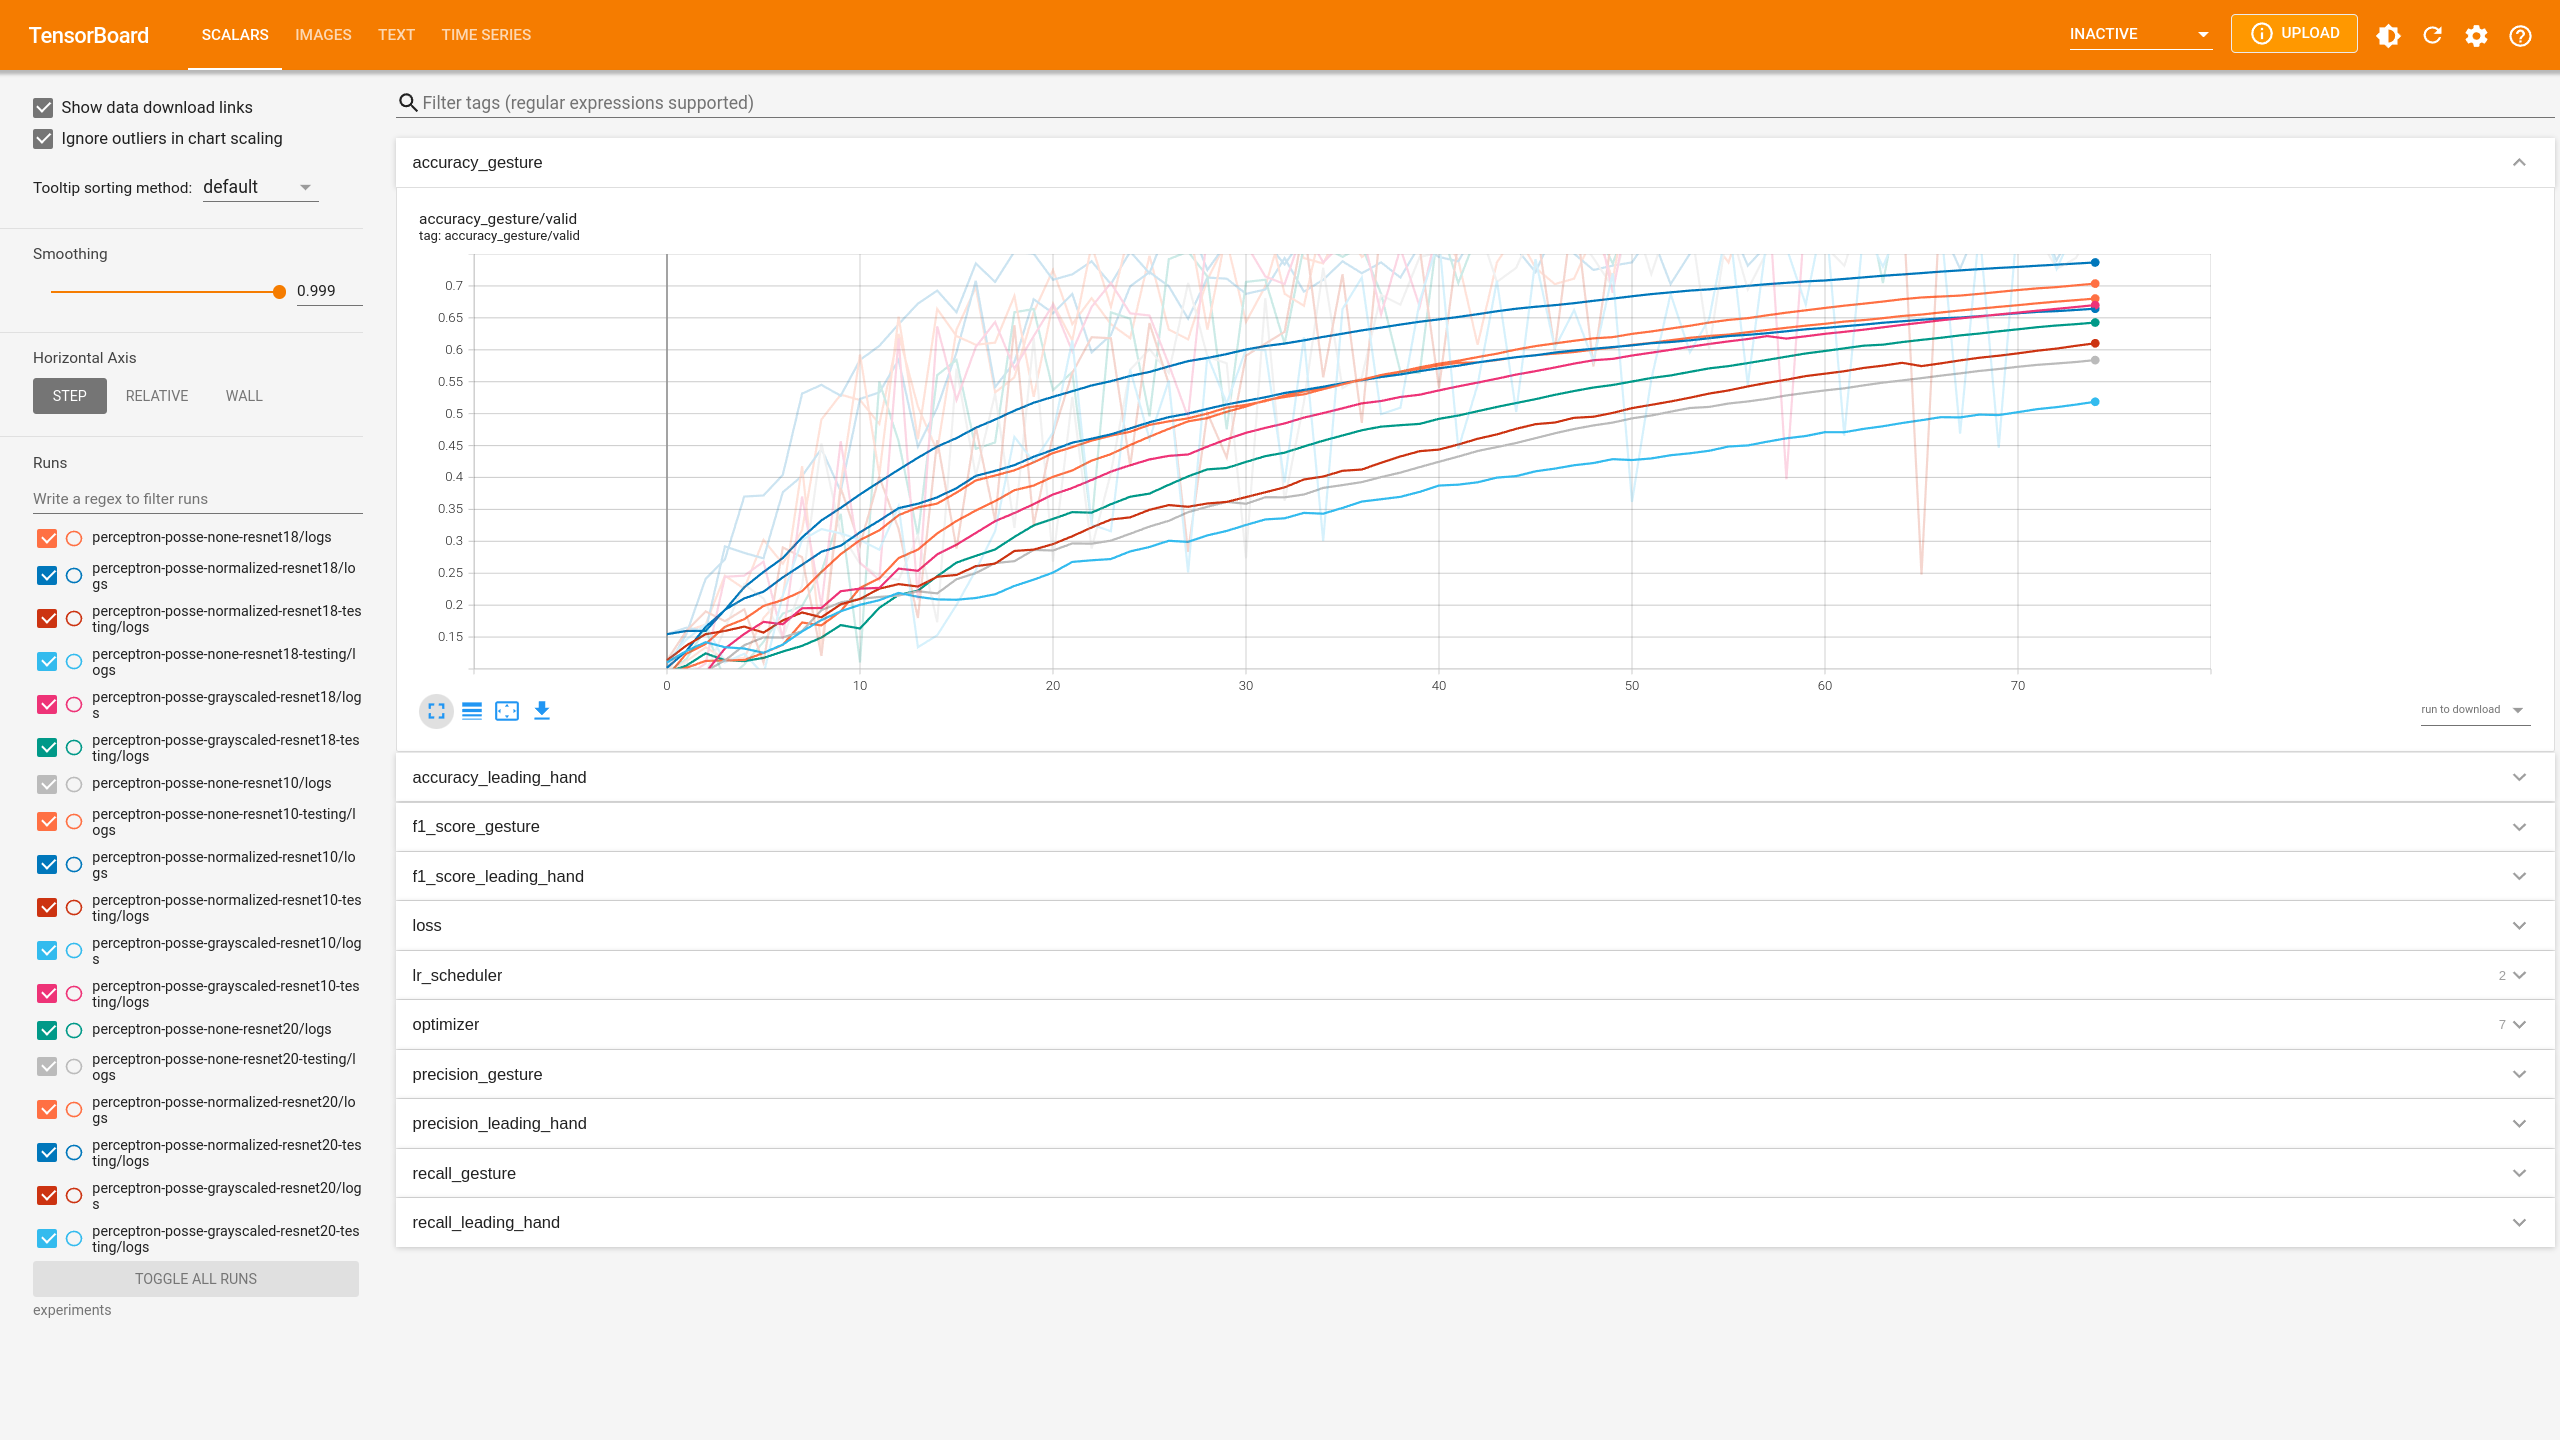

#### *Table 2: Cross Entropy Loss per 1000 training steps*

| **Net**  | **Prep**  | **0**  | **1000**  | **2000**  | **3000**  | **3500**  |
|----------|-----------|--------|-----------|-----------|-----------|-----------|
| 18       | None      | 3.182  | 0.212     | 0.032     | 0.02      | 8.527e-3  |
| 18       | Norm      | 3.202  | 0.095     | 0.028     | 5.979e-3  | 5.159e-3  |
| 18       | Gray      | 3.192  | 0.164     | 0.120     | 7.074e-3  | 6.598e-3  |
| 10       | None      | 3.141  | 0.517     | 0.187     | 0.021     | 0.020     |
| 10       | Norm      | 3.152  | 0.397     | 0.197     | 0.028     | 0.050     |
| 10       | Gray      | 3.14   | 0.602     | 0.198     | 0.038     | 0.033     |
| 20       | None      | 3.267  | 0.277     | 0.075     | 7.753e-3  | 4.650e-3  |
| 20       | Norm      | 3.262  | 0.239     | 0.059     | 0.016     | 4.667e-3  |
| 20       | Gray      | 3.279  | 0.337     | 0.055     | 0.013     | 0.035     |

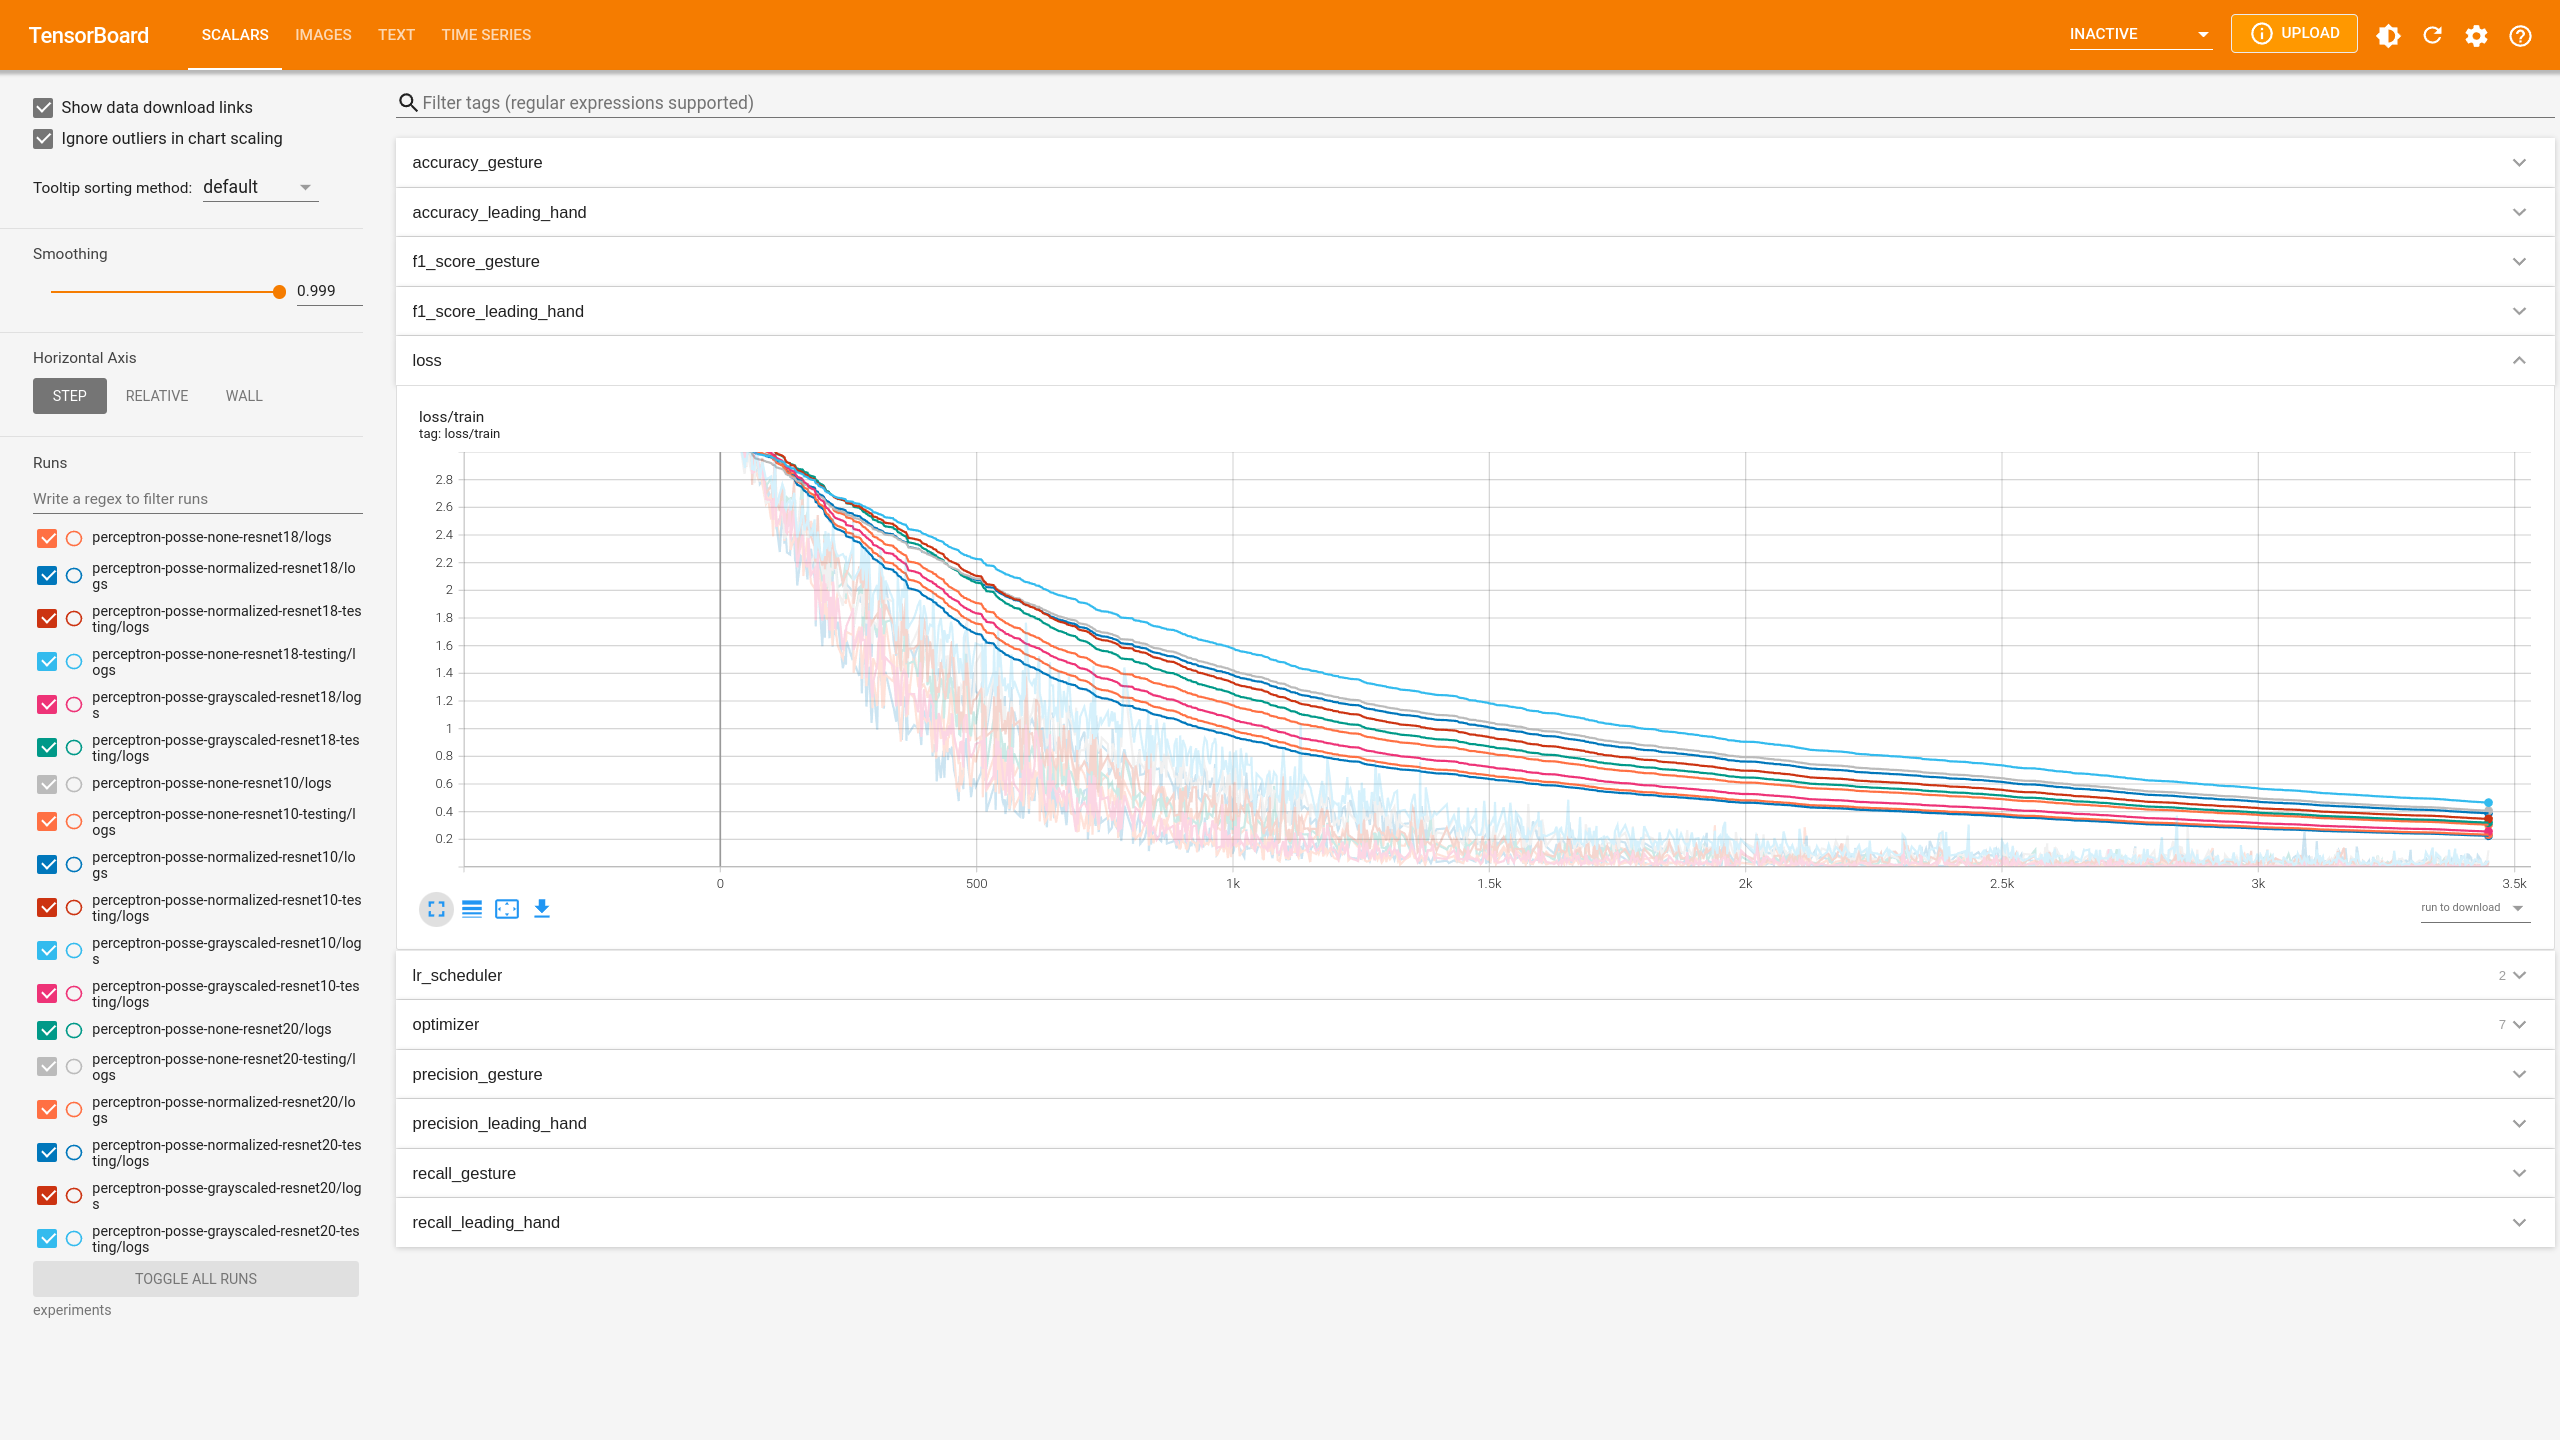

#### *Table 3: F1 Score per 20 Epochs and Final F1 Score*

| **Net**  | **Prep**  | **20**  | **40**  | **60**  | **75**  | **Test**  |
|----------|-----------|---------|---------|---------|---------|-----------|
| 18       | None      | 0.661   | 0.806   | 0.879   | 0.895   | 0.910     |
| 18       | Norm      | 0.710   | 0.788   | 0.782   | 0.860   | 0.907     |
| 18       | Gray      | 0.668   | 0.800   | 0.850   | 0.881   | 0.914     |
| 10       | None      | 0.254   | 0.751   | 0.761   | 0.802   | 0.875     |
| 10       | Norm      | 0.656   | 0.744   | 0.758   | 0.801   | 0.863     |
| 10       | Gray      | 0.460   | 0.768   | 0.822   | 0.840   | 0.857     |
| 20       | None      | 0.529   | 0.800   | 0.828   | 0.826   | 0.908     |
| 20       | Norm      | 0.715   | 0.787   | 0.810   | 0.856   | 0.900     |
| 20       | Gray      | 0.453   | 0.565   | 0.785   | 0.889   | 0.913     |

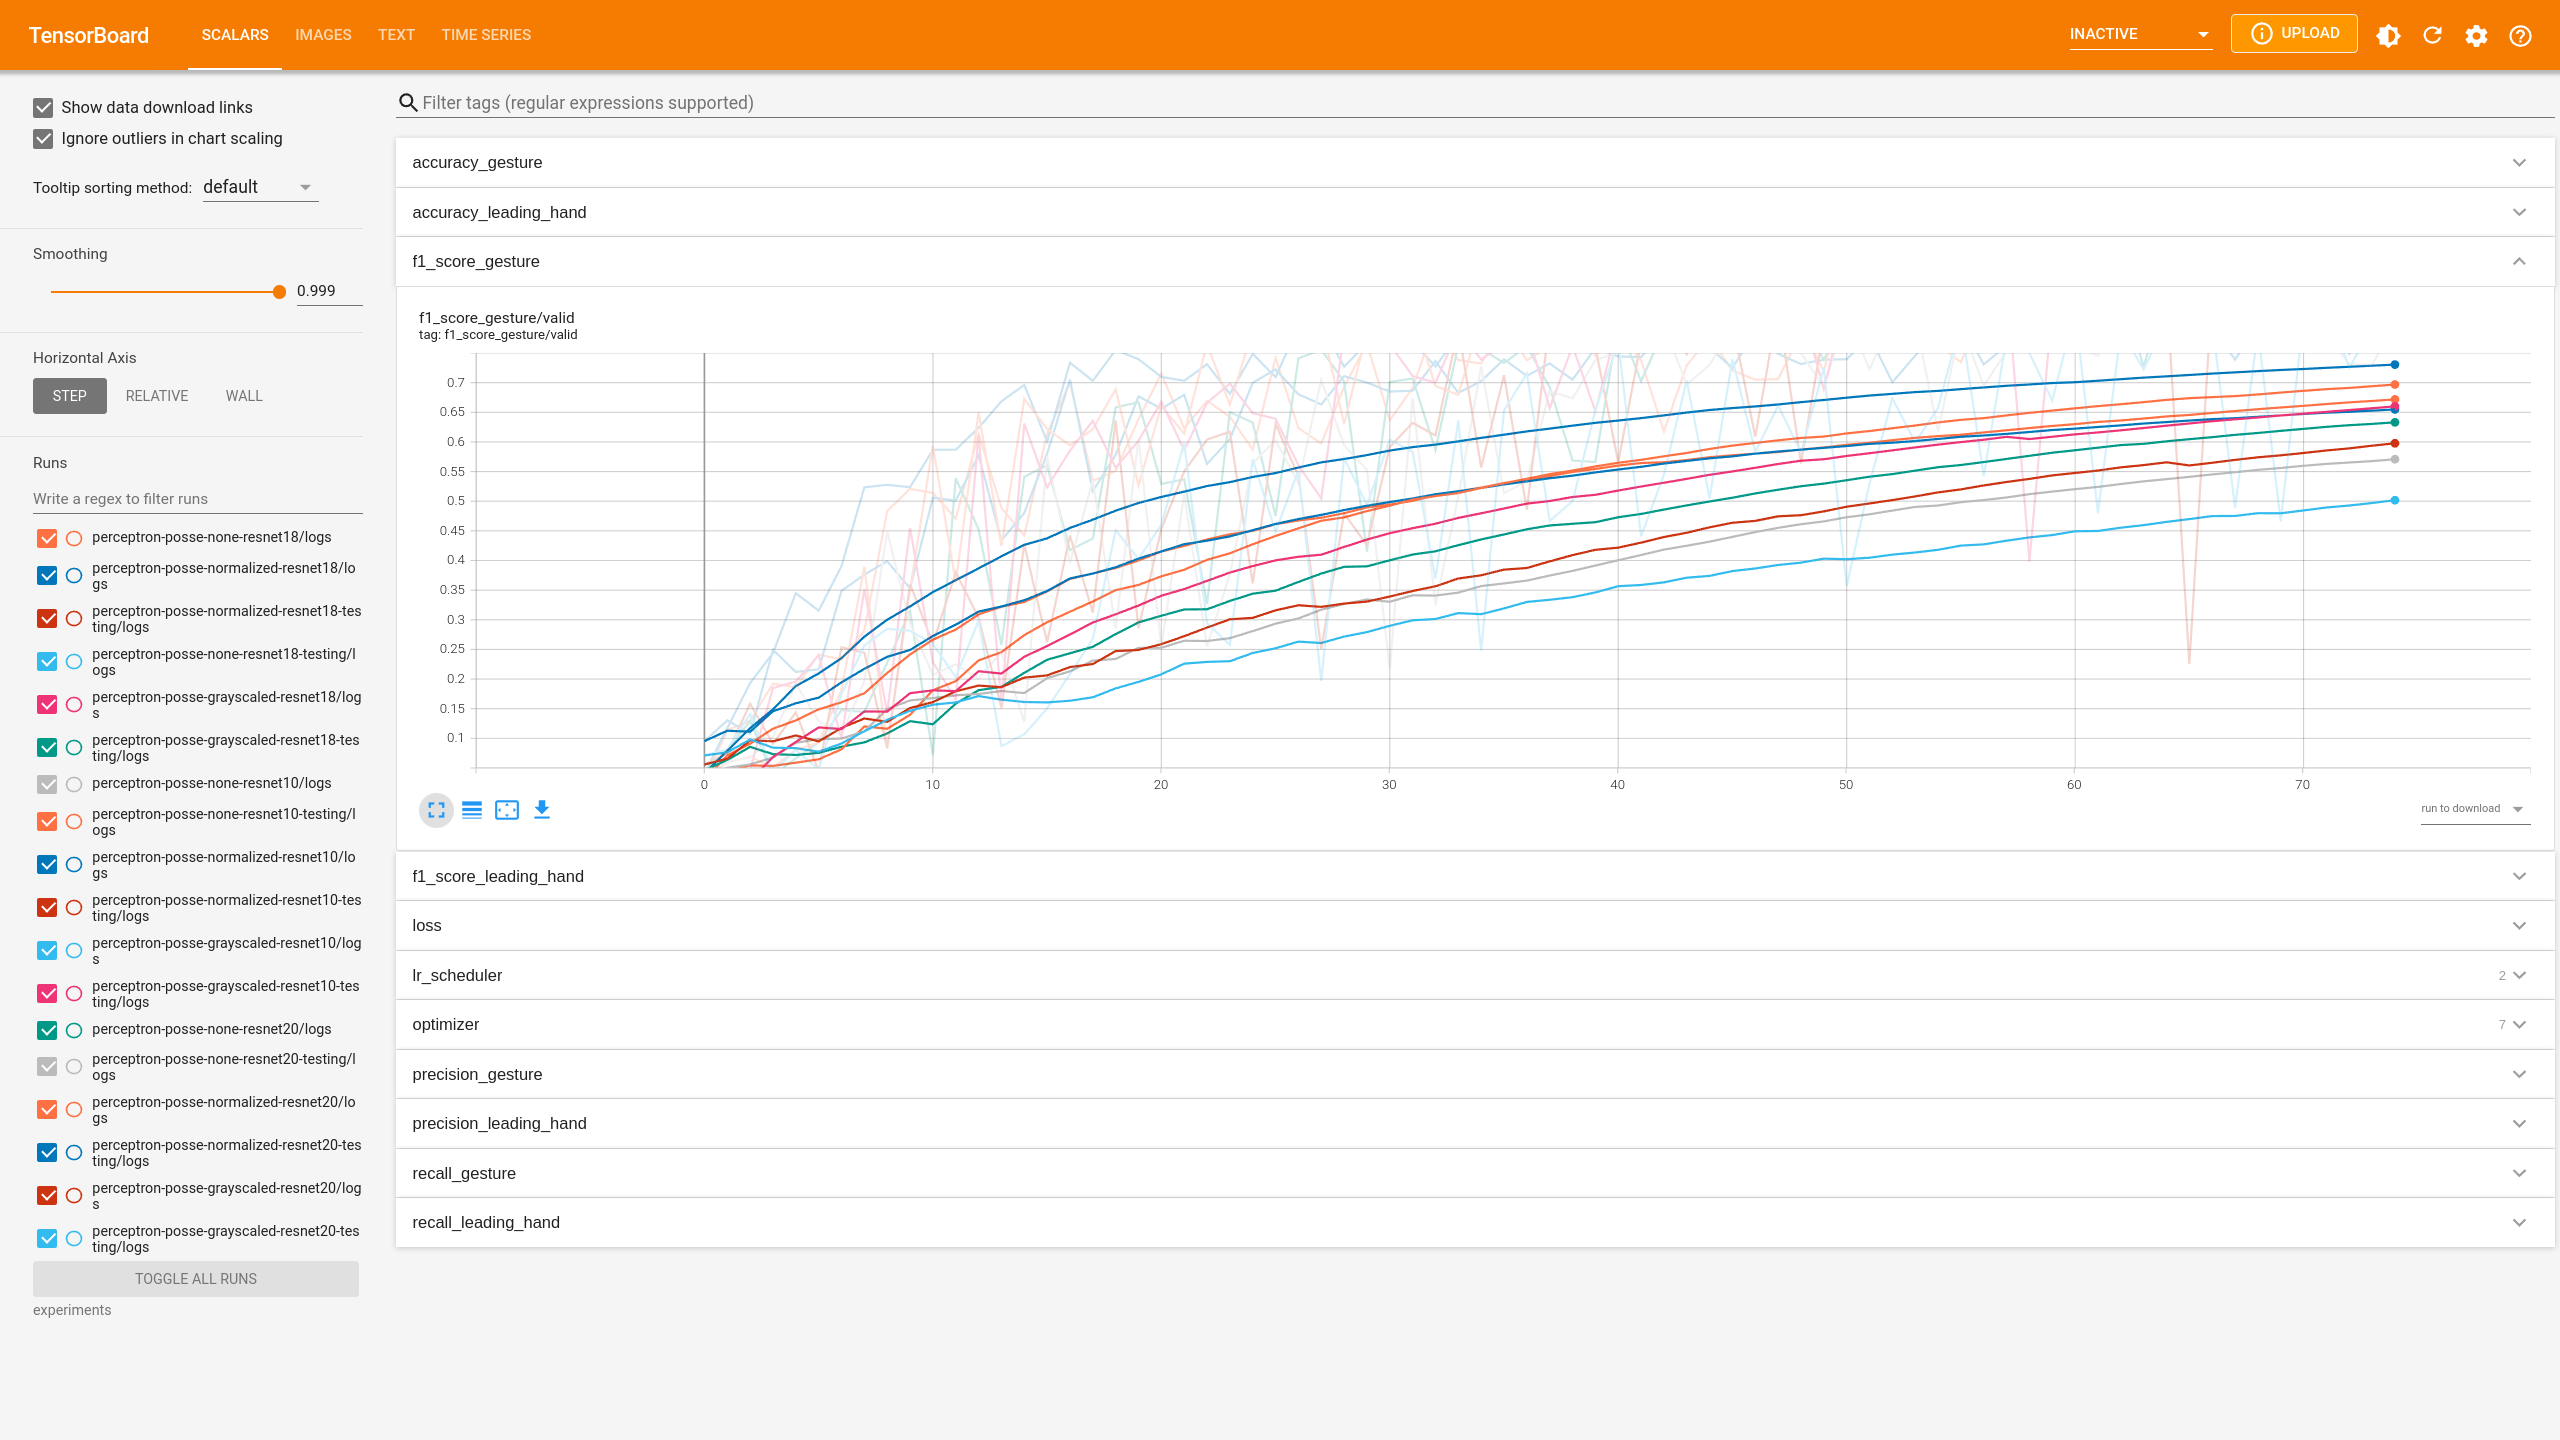



Note that all models were only trained to 75 epochs. This is because higher epoch values led to computer memory issues.

Inspection of all three models training shows that Normalised converges the quickest, it then plateaus as the epoch increases. On the other hand, None and Grayscale are slower to converge but eventually plateau at a higher accuracy threshold.

Inspection of all 3 models performance seems to indicate that grayscaling performed the best, with the highest accuracy scores for both resnet18 and 20. Unalteration performed slightly worse with the highest accuracy score for resnet10, and finally normalisation performed the worst.

Surprisingly, all permutations of the models and preprocessing options performed better on the test set. This variation is noticeable for unaltered images where the average difference seems to be 0.055. Normalised closely followed with an average difference value of 0.051. Grayscale images had the smallest average difference by a signficant margin, reflected by its value of 0.017.

Inspection of the confusion matrices seems to indicate that the model struggled the most in separating “Call” and “Like”. This was followed by “Stop”, “Peace” and their respective inverted counterparts. The model also seemed to preemptively classify a significant amount of images as "No Gesture".



## Confusion Matrices

#### *ResNet18-None*

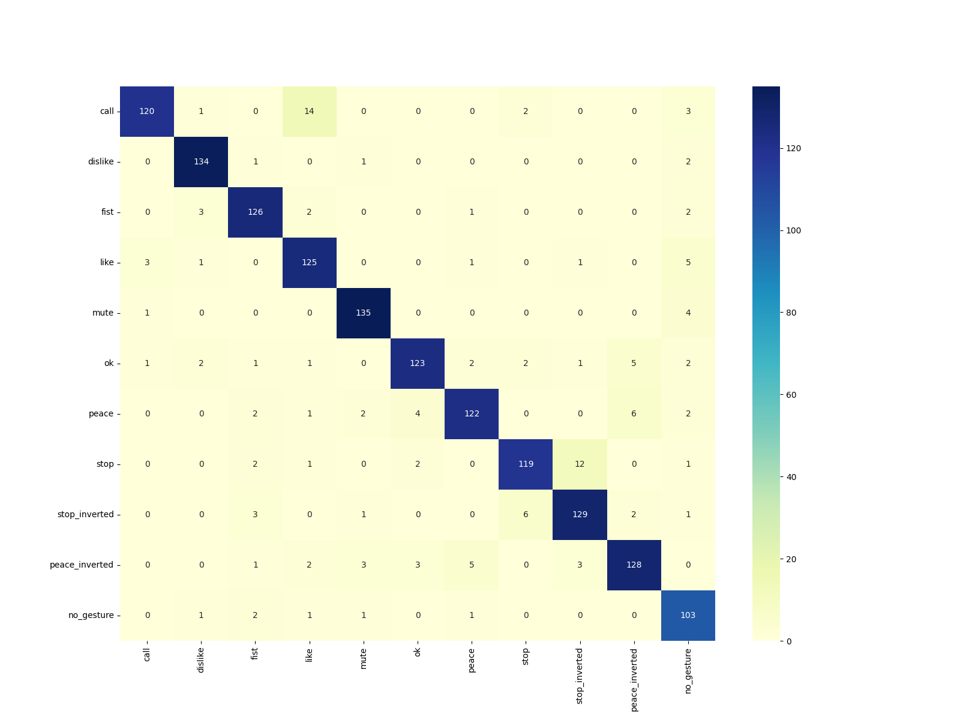

#### *ResNet18-Normalised*

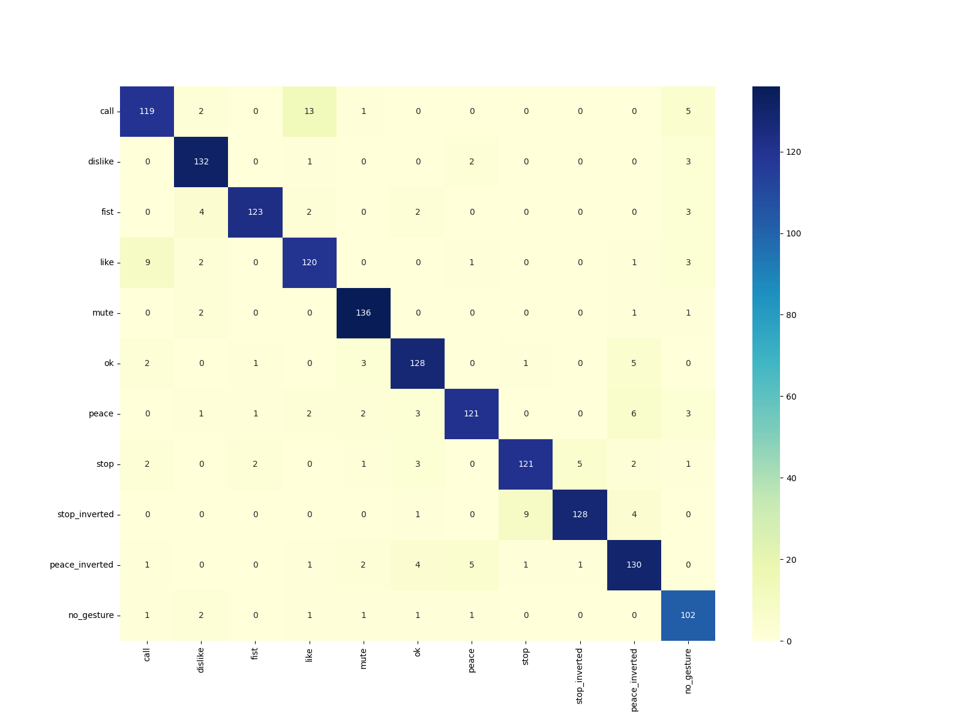

#### *ResNet18-Grayscaled*

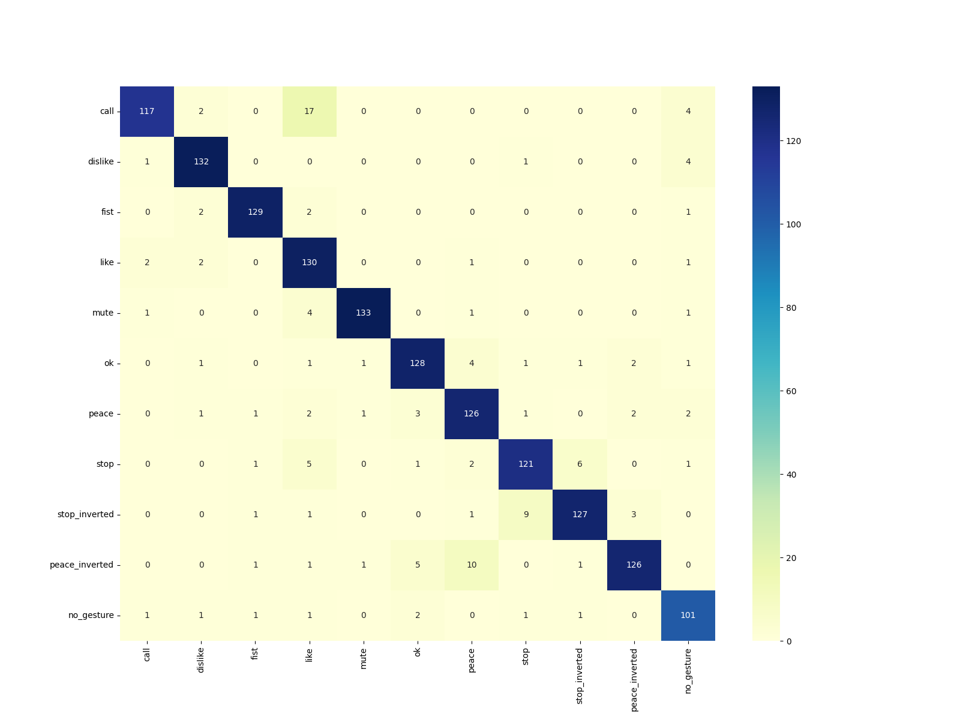

#### *ResNet10-None*

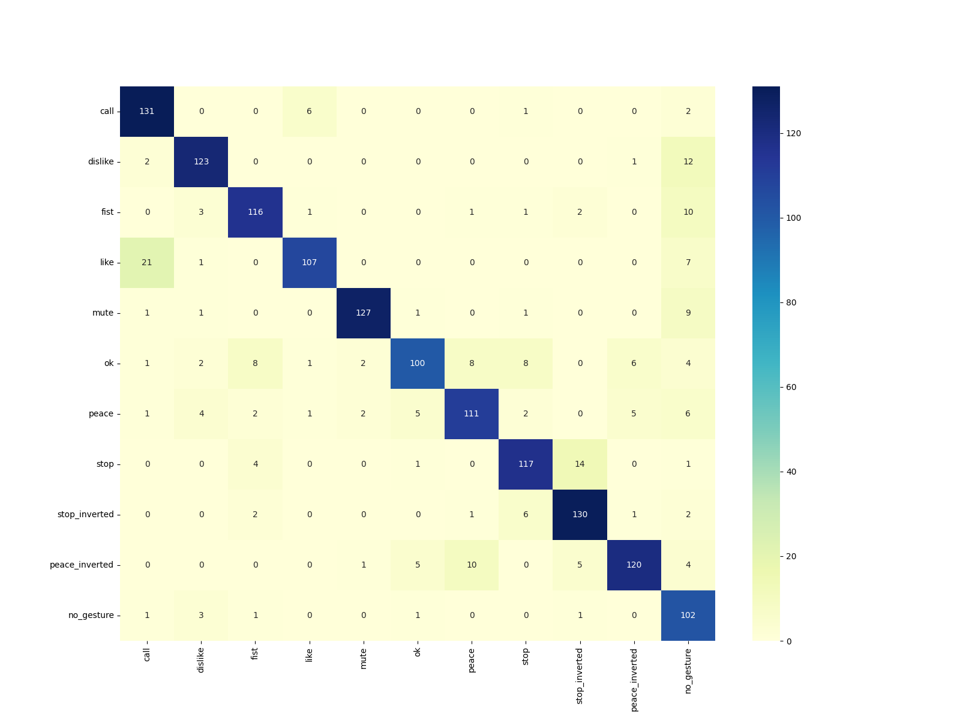

#### *ResNet10-Normalised*

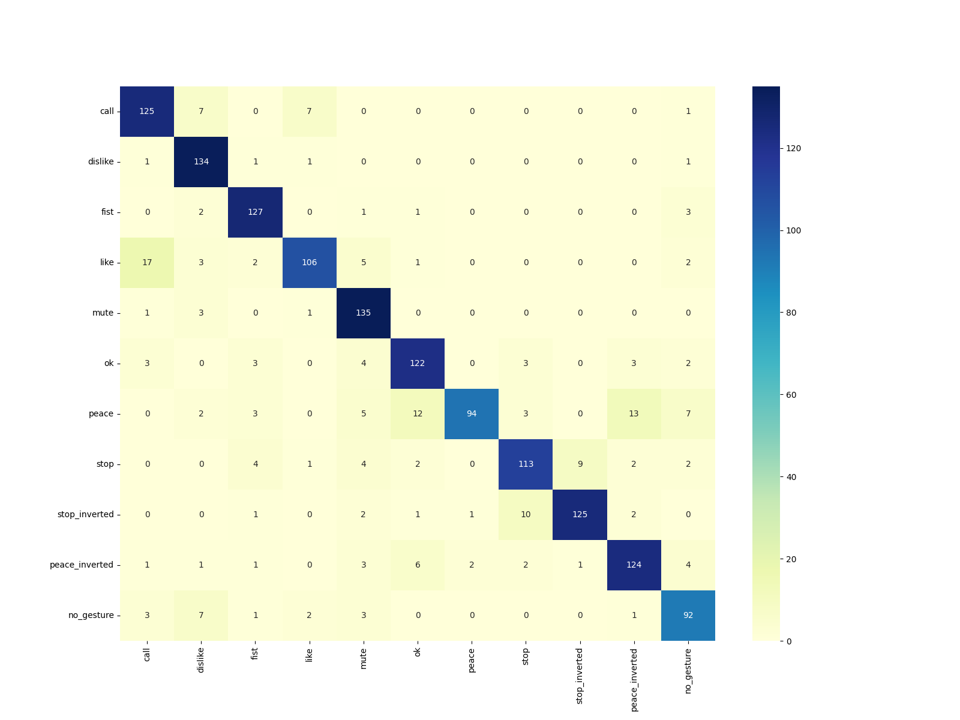

#### *ResNet10-Grayscaled*

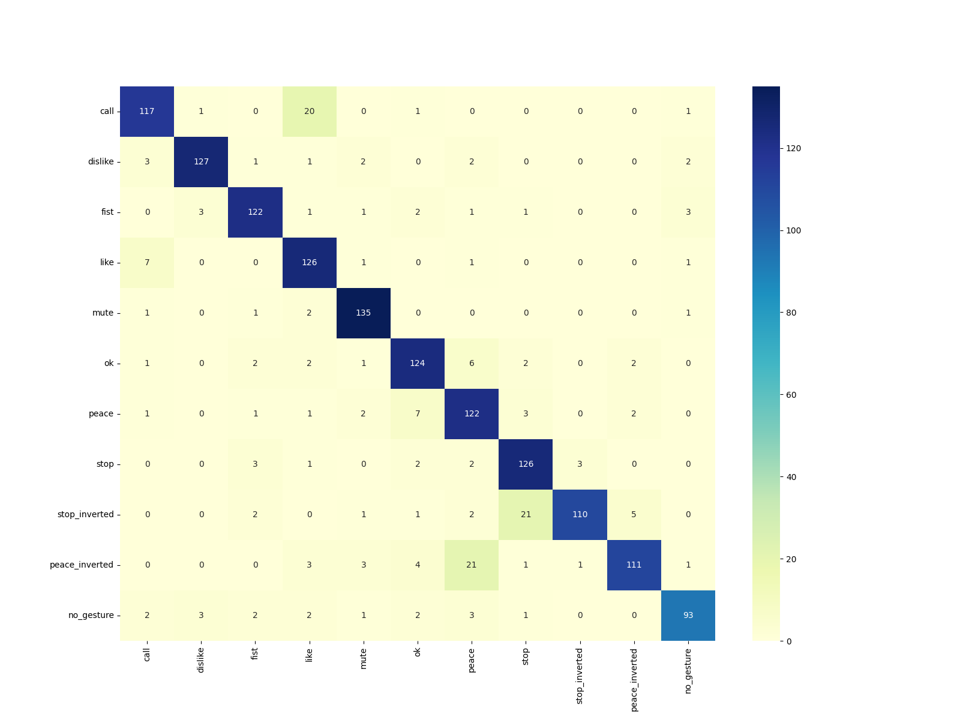

#### *ResNet20-None*

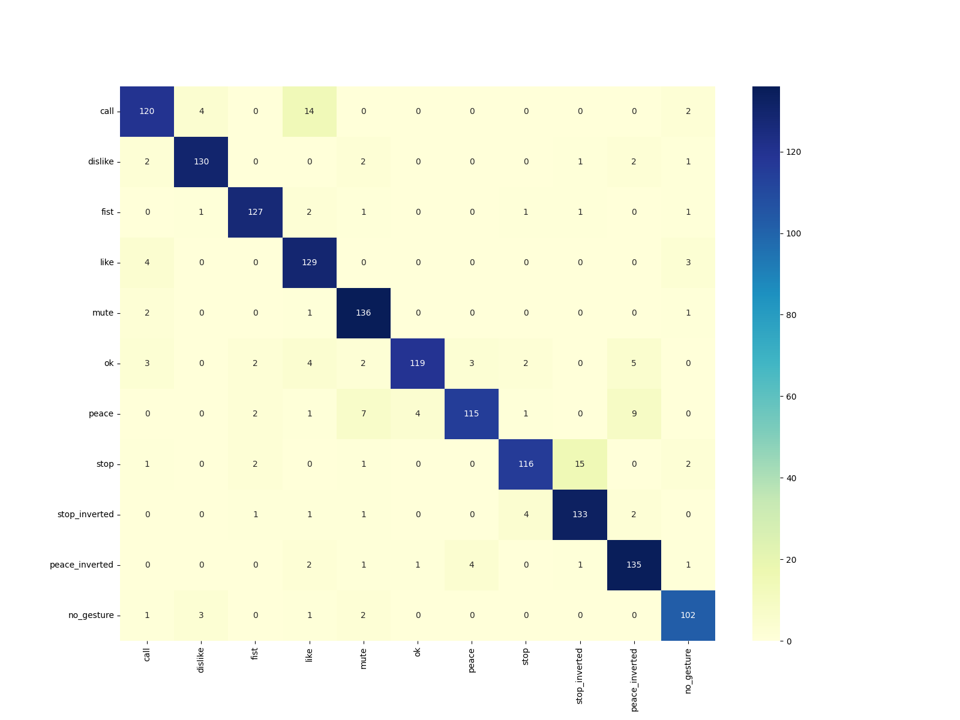

#### *ResNet20-Normalised*

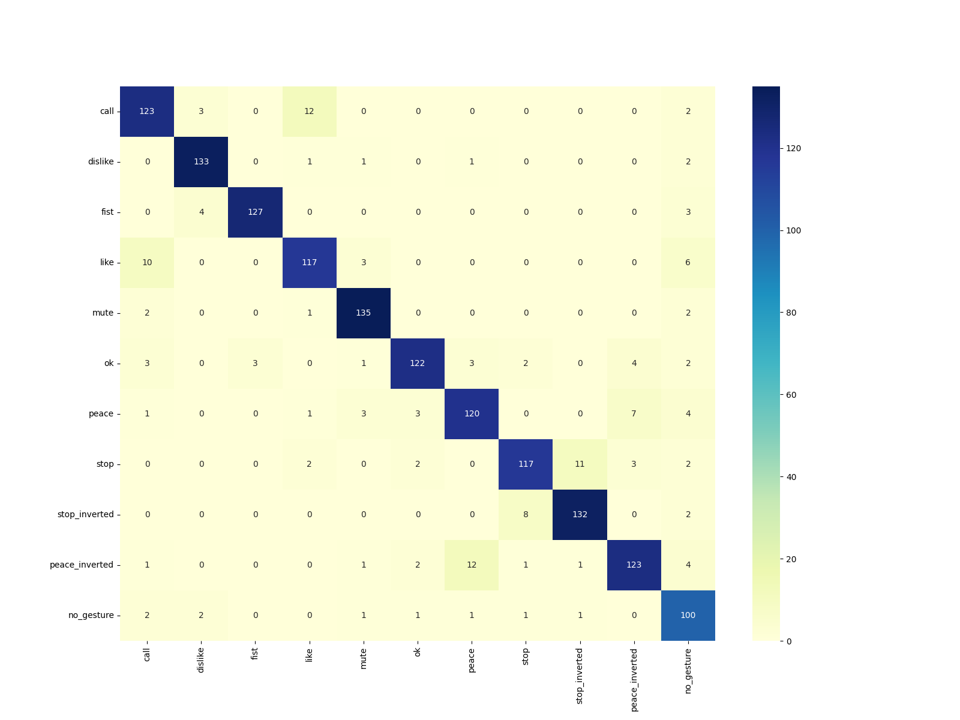

#### *ResNet20-Grayscaled*

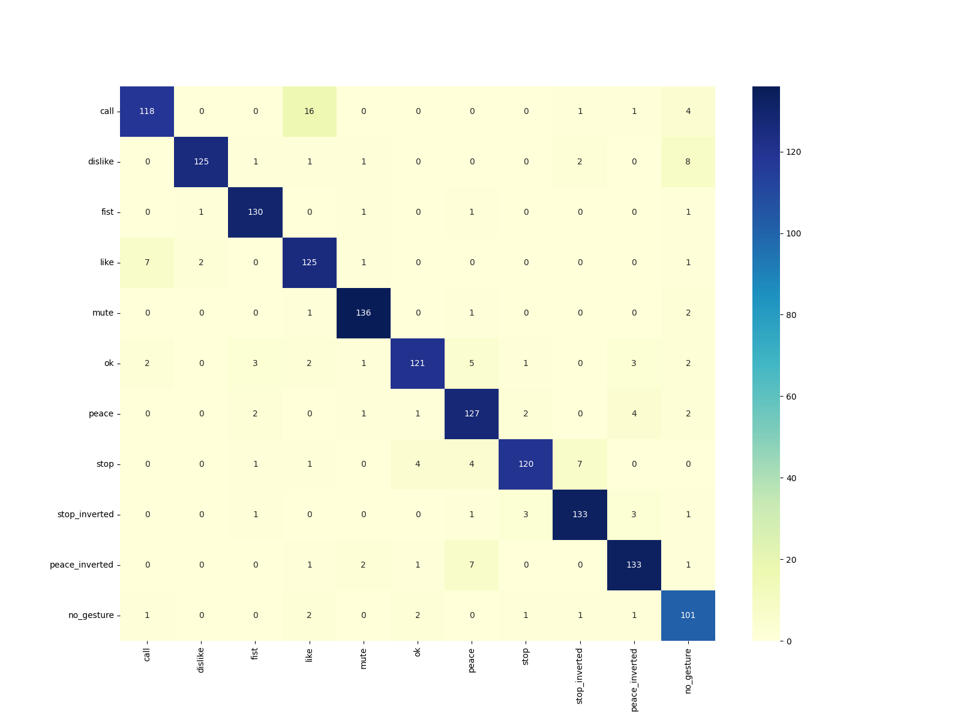


## Metric Logging

Code that logs metrics to TensorBoard, to be easily visualised. It logs a number of metrics, but as mentioned we focus on Accuracy, F1 Score, and Cross Entropy Loss

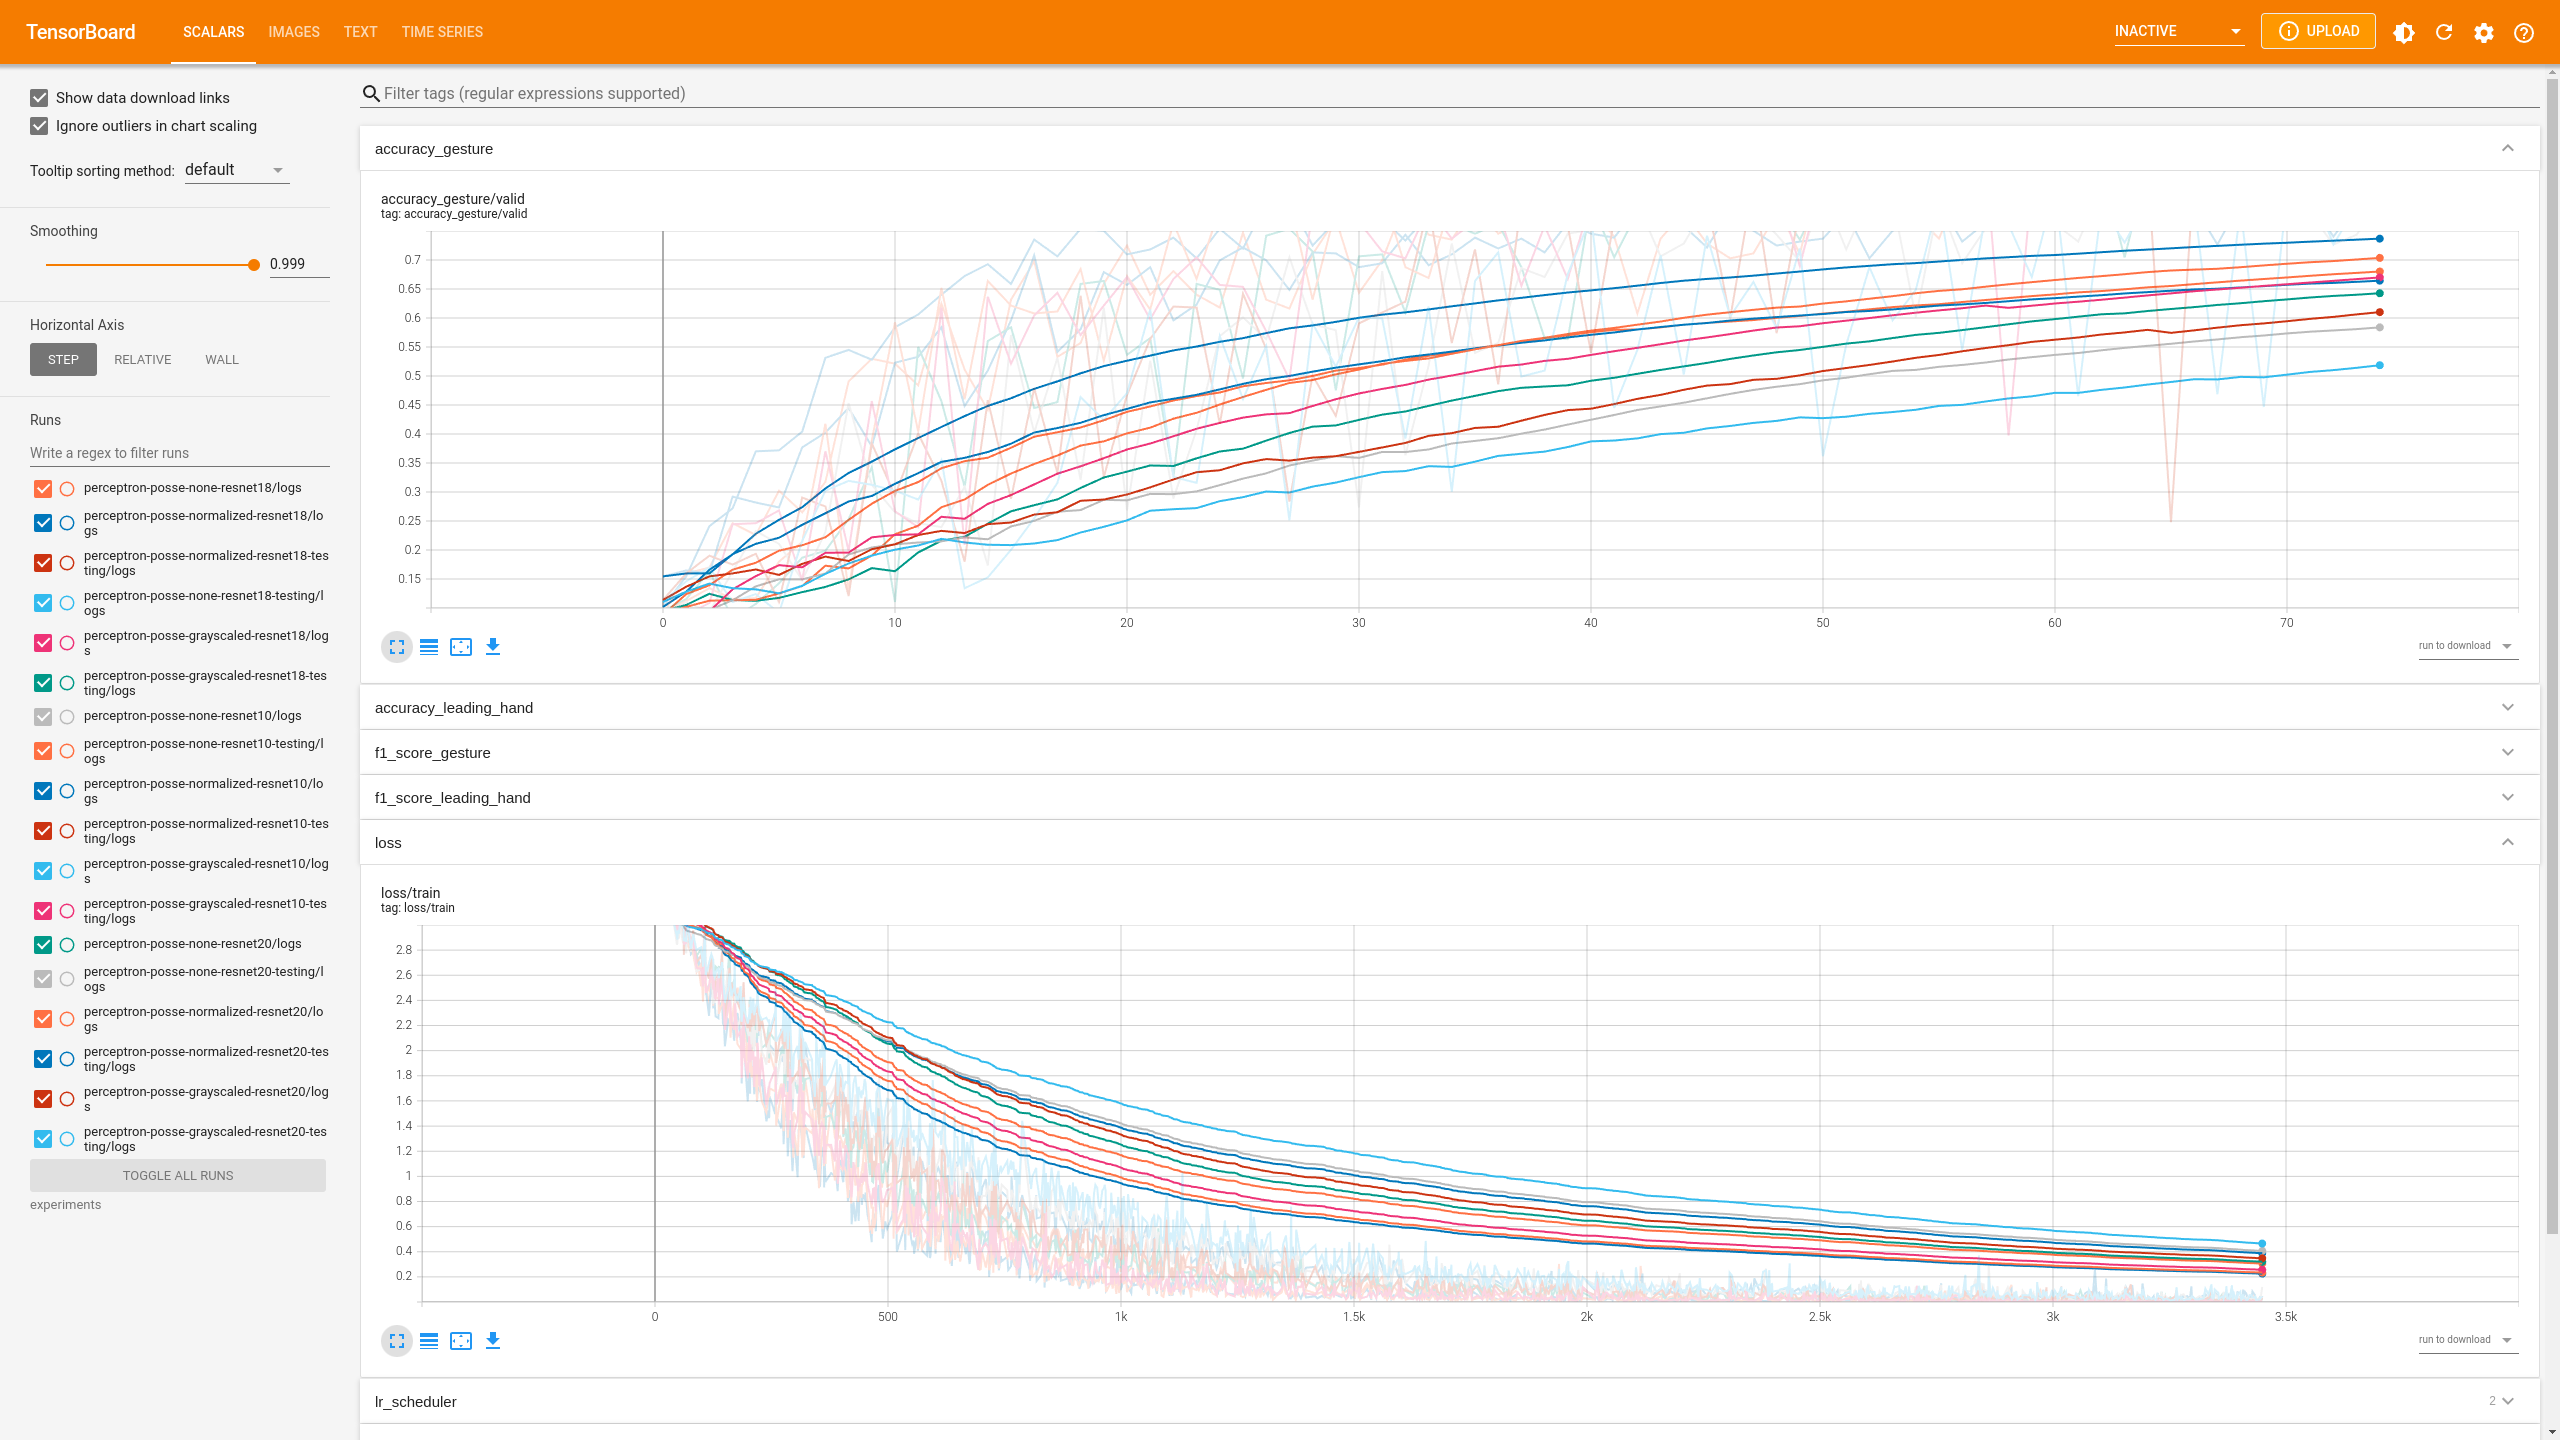

In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict
from torch import Tensor
from omegaconf import DictConfig
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional import accuracy, f1_score, precision, recall, auroc, confusion_matrix

ModuleNotFoundError: No module named 'torch'

In [ ]:
'''
metrics.py
'''

def get_metrics(targets: Tensor, predicts: Tensor, conf: DictConfig, epoch: int, mode: str, writer: SummaryWriter,
                target: str = "gesture") -> Dict:
    """
    Calc metrics for predicted labels

    Parameters
    ----------
    targets : Tensor
        Target class labels
    predicts : Tensor
        Predicted class labels
    conf : DictConfig
        Config
    epoch : int
        Number of epoch
    mode : str
        Mode valid or train
    writer : SummaryWriter
        Tensorboard log writer
    target : str
        Target name: gesture or leading_hand
    """
    average = conf.metric_params["average"]
    metrics = conf.metric_params["metrics"]
    num_classes = conf.num_classes[target]
    predicts_labels = torch.argmax(predicts, dim=1)
    scores = {
        "accuracy": accuracy(predicts_labels, targets, average=average, num_classes=num_classes),
        "f1_score": f1_score(predicts_labels, targets, average=average, num_classes=num_classes),
        "precision": precision(predicts_labels, targets, average=average, num_classes=num_classes),
        "recall": recall(predicts_labels, targets, average=average, num_classes=num_classes)
    }

    if mode == "test":
        scores["roc_auc"] = auroc(predicts, targets, average=average, num_classes=num_classes)

    needed_scores = {}
    for metric in metrics:
        needed_scores[metric] = round(float(scores[metric]), 6)

    if mode == "valid" or mode == "test":
        if target == "leading_hand":
            class_names = ["right", "left"]
        else:
            class_names = conf.dataset.targets

        cm = confusion_matrix(predicts, targets, num_classes)
        df_cm = pd.DataFrame(cm, index=[i for i in class_names], columns=[i for i in class_names])

        plt.figure(figsize=(16, 12))
        hm = sns.heatmap(df_cm, annot=True, fmt='.5g', cmap="YlGnBu").get_figure()
        writer.add_figure(f"Confusion matrix for {target}", hm, epoch)
    return needed_scores


# Discussion

Observation of the overarching model performance seems to indicate that ResNet18 and ResNet20 were nearly identical performance wise. However, ResNet10 performed significantly poorer. ResNet18 and ResNet20’s performance can be attributed to their more sophisticated architecture, the presence of more layers enables them to model and capture the underlying, nonlinear function to a greater degree.

Further inspection seems to indicate that between ResNet18 and ResNet20, Grayscaling seemed to perform the best, with None and Normalising following. However, grayscaling's performance significantly drops for ResNet10, which showcases that the largest differences in performance seem to be attributed to the chosen model instead of the chosen preprocessing option, although the chosen preprocessing option still has some impact. In addition to this, grayscaling’s ability to boost the models predictive power can be attributed to its ability to reduce the lighting and colour information that is redundant. By reducing the noise associated with these factors in the images, the models are able to exclusively train on the shape of the hand.

Exploring the impact of the preprocessing methods on the training yields quite a few interesting insights. Normalisation significantly improves the training speed in terms of accuracy gained vs epochs. This can be attributed to the fact that normalisation makes all inputs (in our case pixels) weighted equally. However in the long run, this is not suitable for the task at hand as pixels closer to the centre of the bounding box play a more pivotal part in gesture classification. On the other hand, grayscaling seemed to converge the slowest, this may be because it inherently has less information to work with initially, however, as it converges to the true function, the reduced information aids it.

Taking both the preprocessing and model options into account, we can reasonably conclude that the biggest differences in performance seem to be attributed to the chosen model instead of the chosen preprocessing option, but the preprocessing option still has some impact.

In the context of AR/VR it is quintessential to identify distinct hand gestures with high accuracy and efficiency. As a result of this, the two primary criteria we used to evaluate models were their predictive power and their training time. With respect to this criteria, we believe that the ResNet18 is the best performing model as it offers near identical performance as ResNet20 but has significantly less parameters to learn.

Finally, a holistic examination of the training time seems to reflect that it becomes exponentially harder to progressively achieve the higher levels of accuracy needed for real-world AR/VR applications, to the extent that complex, state-of-the-art models such as ResNet152 and ResNeXt101 alongside 500,000 images are needed to cross the 99% accuracy threshold. In comparison, an impressive 42% accuracy was able to be achieved in less than 70 images.

Ultimately, after training the ResNet10, ResNet18 and ResNet20 models on our 70:30 split dataset, we came to the conclusion that the ResNet18 model trained on Grayscale data offered the most utility when it came to an AR/VR context. This is due to its relatively quick training time in epochs alongside an impressive accuracy score of 0.914. 

Despite our models impressive predictive power, there were still limitations and areas of improvement that we could have targeted given enough time and resources. Our limited computer processing power, memory and storage made it infeasible to train on larger datasets with a higher maximum epoch limit. Our final results would also have been more reliable if we had the time to employ 2 or 3 fold cross-validation on our models. In addition to this, proper hyper-parameter tuning with respect to our smaller dataset could also have served as an area of improvement.